In [1]:
import duckdb
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from tqdm import tqdm
from copy import deepcopy
from konlpy.tag import Okt
from datetime import datetime
from datetime import timedelta
from curl_cffi import requests
from wordcloud import WordCloud
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import platform
from matplotlib import font_manager, rc

get_ipython().run_line_magic("matplotlib", "inline")
%matplotlib inline

rc("font", family="Arial Unicode MS")

#### DuckDB에 적재된 데이터프레임 추출

In [2]:
date_filter = '250520'

In [ ]:
# DB 파일 연결
con = duckdb.connect(f'/Users/taeheon/stock_price/data/duckdb/{date_filter}_weekday_sentiment_stock.duckdb')

df = con.execute('SELECT * FROM merged_data').fetchdf()

df.tail(3)

,date,1,2,3,4,5,6,7,8,9,...,news_count,avg_negative,avg_neutral,avg_positive,open,high,low,close,volume,label
1069,2025-05-16,"삼성전자, AI '통버블 세탁기' 선봬··· 사용자 편의성↑ ||| [사진=삼성전자...","외국인들, 삼성전자 2900억 쓸어담은 이유가…'깜짝 전망' [종목+] ||| 반도...","미국계 로펌 화이트앤케이스, 삼성전자 獨플랙트 인수 자문 ||| [본 기사는 05월...",None,None,None,None,None,None,...,3,0.0260,0.3437,0.6300,57400.0,57500.0,56700.0,56800.0,10385352,0
1070,2025-05-19,"용석우 삼성전자 사장, 전자정보통신산업진흥회장 취임 ||| 용석우 제21대 한국전자...","삼성전자 OLED TV, 엔비디아 지싱크 호환 인증 ||| 삼성전자(005930)는...",[주식 초고수는 지금]'6만 전자' 기대감…삼성전자 순매수 1위 ||| 미래에셋증권...,"용석우 삼성전자 사장, KEA 회장 취임 “AI·공급망 대응 주력” ||| 공급망·...",[충무로에서] 화웨이·삼성전자의 같지만 다른 35조원 ||| '대륙의 실수' 기업 ...,전자정보통신산업진흥회장에 용석우 삼성전자 사장 취임 ||| 용석우 삼성전자 영상디스...,None,None,None,...,6,0.0528,0.6087,0.3385,56400.0,56400.0,55500.0,55800.0,9802105,1
1071,2025-05-20,"“가격 최대 30% 올리겠습니다”...TSMC 결정에 미소짓는 삼성전자, 왜? ||...","삼성전자, 전략 리더십 재정비 AI 중심 ‘뉴삼성’ 본격 시동 ||| 삼성전자가 다...",None,None,None,None,None,None,None,...,2,0.1680,0.7315,0.1010,56200.0,56700.0,55700.0,55900.0,9080577,0


In [4]:
con.close()

# 1. 데이터 개요 및 결측치 확인
#### 데이터 통계

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1072 non-null   object 
 1   1             1063 non-null   object 
 2   2             1045 non-null   object 
 3   3             998 non-null    object 
 4   4             924 non-null    object 
 5   5             839 non-null    object 
 6   6             740 non-null    object 
 7   7             637 non-null    object 
 8   8             548 non-null    object 
 9   9             456 non-null    object 
 10  10            378 non-null    object 
 11  11            308 non-null    object 
 12  12            243 non-null    object 
 13  13            190 non-null    object 
 14  14            155 non-null    object 
 15  15            126 non-null    object 
 16  16            97 non-null     object 
 17  17            80 non-null     object 
 18  18            62 non-null   

In [6]:
df.describe()

,news_count,avg_negative,avg_neutral,avg_positive,open,high,low,close,volume,label
count,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1.072000e+03,1072.000000
mean,8.583955,0.179278,0.348974,0.471748,69375.932836,69971.268657,68744.682836,69300.652985,1.678411e+07,0.443097
std,5.360788,0.203902,0.238352,0.251920,9538.419001,9552.306006,9435.838157,9493.840430,8.559965e+06,0.496983
min,0.000000,0.000000,0.000000,0.000000,50200.000000,51400.000000,49900.000000,49900.000000,0.000000e+00,0.000000
25%,5.000000,0.006075,0.174375,0.291225,60800.000000,61300.000000,60200.000000,60600.000000,1.177102e+07,0.000000
50%,8.000000,0.115050,0.323650,0.495950,70200.000000,70900.000000,69800.000000,70200.000000,1.496740e+07,0.000000
75%,11.000000,0.268450,0.490250,0.655825,77400.000000,77800.000000,76525.000000,77200.000000,2.001014e+07,1.000000
max,39.000000,0.999800,1.000000,0.999900,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07,1.000000


#### 기사 원문 컬럼 개수 파악

In [7]:
# 기사 원문 컬럼 개수
numeric_str_columns = [col for col in df.columns if col.isdigit()]

# 개수 출력
print(f"숫자로 된 문자열 컬럼 개수: {len(numeric_str_columns)}")

숫자로 된 문자열 컬럼 개수: 39


- NaN이 아닌 값의 개수 집계

In [8]:
# NaN/Non-NaN 개수 계산
non_missing_counts = df[numeric_str_columns].notna().sum()
missing_counts = df[numeric_str_columns].isna().sum()

# 원하는 구조로 데이터프레임 생성
missing_summary = pd.DataFrame(
    [non_missing_counts.values, missing_counts.values],
    index=['Not NaN 개수', 'NaN 개수'],
    columns=numeric_str_columns
)

# 결과 확인
missing_summary

,1,2,3,4,5,6,7,8,9,10,...,30,31,32,33,34,35,36,37,38,39
Not NaN 개수,1063,1045,998,924,839,740,637,548,456,378,...,9,8,8,4,4,2,1,1,1,1
NaN 개수,9,27,74,148,233,332,435,524,616,694,...,1063,1064,1064,1068,1068,1070,1071,1071,1071,1071


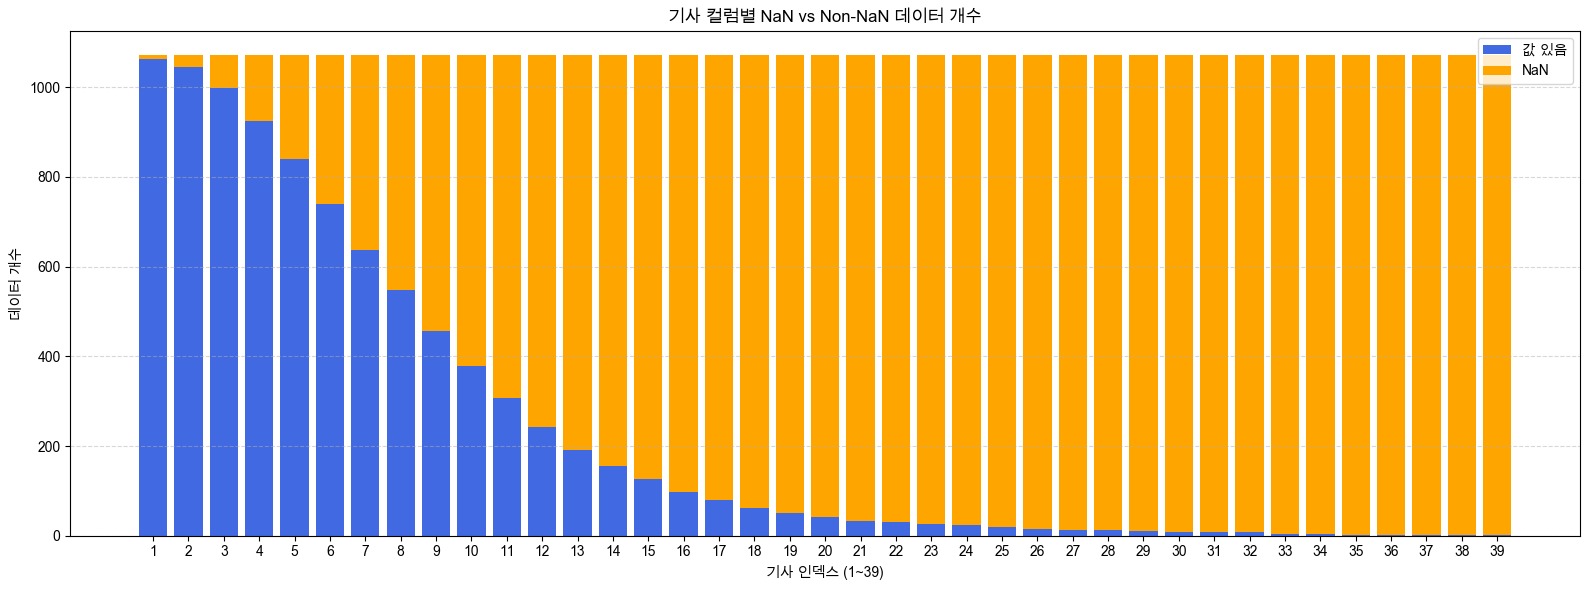

In [9]:
# NaN 아닌 값 개수
non_missing_counts = df[numeric_str_columns].notna().sum()
# NaN 값 개수
missing_counts = df[numeric_str_columns].isna().sum()

# 누적 막대그래프
plt.figure(figsize=(16, 6))
plt.bar(numeric_str_columns, non_missing_counts, label='값 있음', color='royalblue')
plt.bar(numeric_str_columns, missing_counts, bottom=non_missing_counts, label='NaN', color='orange')

plt.title('기사 컬럼별 NaN vs Non-NaN 데이터 개수')
plt.xlabel('기사 인덱스 (1~39)')
plt.ylabel('데이터 개수')
plt.xticks(rotation=0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### 전체 수집 날짜 수, 기사 수 통계

In [10]:
# 전체 수집 날짜 수
total_dates = df['date'].nunique()

# 전체 수집 기사 수 (각 날짜의 news_count 합산)
total_news_cnt = df['news_count'].sum()

print(f"전체 수집 날짜 수 : {total_dates}")
print(f"전체 수집 기사 수 : {total_news_cnt}")

전체 수집 날짜 수 : 1072
전체 수집 기사 수 : 9202


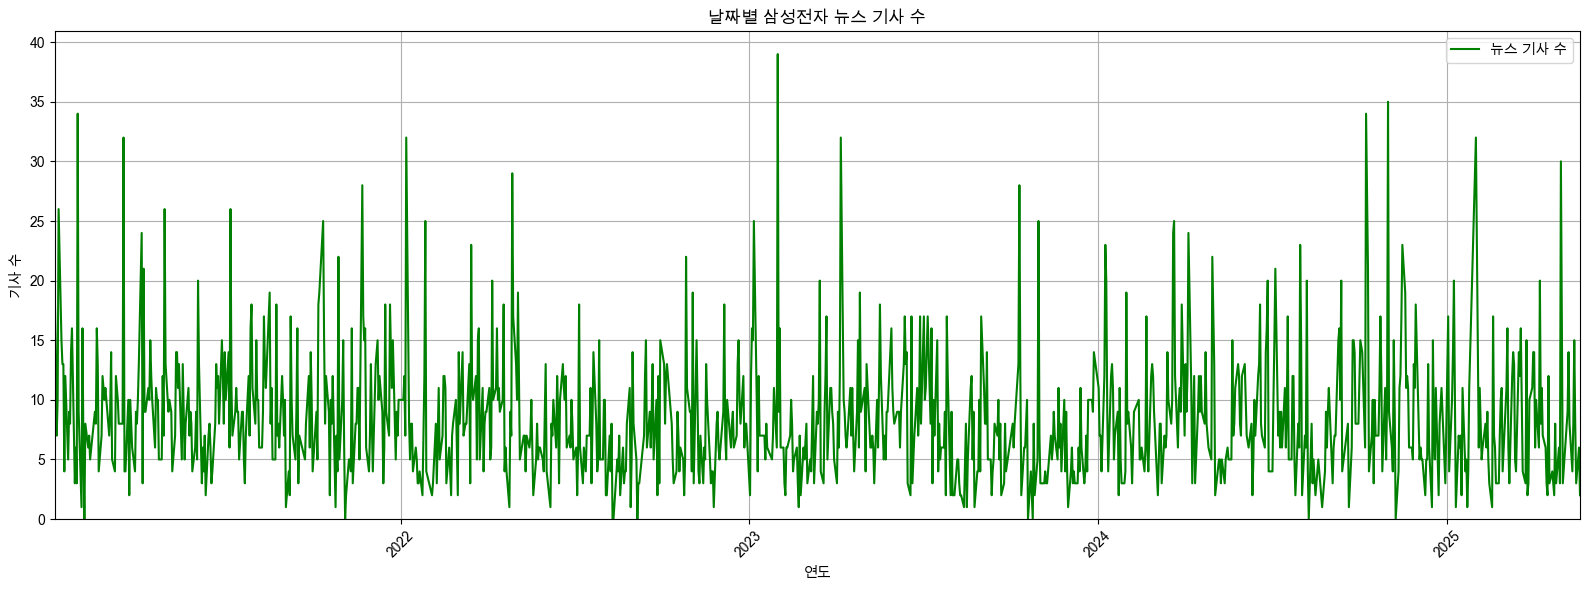

In [11]:
import matplotlib.dates as mdates

# 날짜 파싱 및 유효한 날짜만 필터링
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # 잘못된 날짜는 NaT로 처리
df = df.dropna(subset=['date'])  # NaT 제거

# 시각화
plt.figure(figsize=(16, 6))
plt.plot(df['date'], df['news_count'], label='뉴스 기사 수', color='green')

plt.title("날짜별 삼성전자 뉴스 기사 수")
plt.xlabel("연도")
plt.ylabel("기사 수")

# x축: 연도만 표시
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # 매년
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 연도만 텍스트로

# x축 라벨 회전
plt.xticks(rotation=45)

# y축 0부터 시작
plt.xlim(left=df['date'].min(), right=df['date'].max())
plt.ylim(bottom=0)

# 그리드 및 범례
plt.grid(True)
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()

#### 기사 수가 가장 많은 날과 가장 적은 날 비교
- 각 날짜의 기사 개수와 감성 확률

In [51]:
# 기사 수가 가장 많은 날
max_news_count = df['news_count'].max()
most_articles_df = df[df['news_count'] == max_news_count]

# 기사 수가 0인 날 (가장 적은 날)
least_articles_df = df[df['news_count'] == 0]

In [13]:
print(f"기사 수 가장 많은 날 : 기사 {most_articles_df['news_count'].item()}개")
most_articles_df

기사 수 가장 많은 날 : 기사 39개


,date,1,2,3,4,5,6,7,8,9,...,news_count,avg_negative,avg_neutral,avg_positive,open,high,low,close,volume,label
511,2023-01-31,"삼성전자, 오늘 지난해 4분기 확정 실적 공개한다 ||| [사진=연합뉴스] 삼성전자...","삼성전자, 확정실적 발표…반도체 감산 선언하나 ||| 지난해 4분기 잠정실적 발표에...",FOMC 앞둔 美증시 하락…삼성전자 '반도체 감산' 여부 주목 [모닝브리핑] |||...,반도체 한파…삼성전자 감산 여부 주목 [증시 개장 전 꼭 알아야 할 5가지] |||,"삼성전자, 오스카상 영화감독과 협업…갤럭시 촬영 단편영화 공개 ||| 삼성전자가 오...","삼성전자, 4분기 반도체 영업익 0.27조, 전년比 96.94% 폭락…가전은 적자 ...","삼성전자, 작년 영업익 43조3766억…전년비 16% 감소[주목 e공시] ||| 삼...","[1보] 삼성전자, 지난해 연 매출 300조 돌파…영업익 16% 감소 ||| 삼성전...","삼성전자, 보통주 361원·우선주 362원 현금배당 결정[주목 e공시] ||| 삼성...",...,39,0.5492,0.1953,0.2555,63500.0,63700.0,61000.0,61400.0,163847,0


In [52]:
print(f"기사 수 적은 날 : {len(least_articles_df)}일")
least_articles_df

기사 수 적은 날 : 9일


,date,1,2,3,4,5,6,7,8,9,...,news_count,avg_negative,avg_neutral,avg_positive,open,high,low,close,volume,label
23,2021-02-04,None,None,None,None,None,None,None,None,None,...,0,0.0,1.0,0.0,83500.0,83800.0,82100.0,82500.0,24171688,1
207,2021-11-04,None,None,None,None,None,None,None,None,None,...,0,0.0,1.0,0.0,71200.0,71600.0,70500.0,70600.0,11818987,0
396,2022-08-11,None,None,None,None,None,None,None,None,None,...,0,0.0,1.0,0.0,59600.0,60000.0,59300.0,59900.0,15141941,1
397,2022-08-12,None,None,None,None,None,None,None,None,None,...,0,0.0,1.0,0.0,59500.0,60700.0,59400.0,60200.0,10786658,1
413,2022-09-06,None,None,None,None,None,None,None,None,None,...,0,0.0,1.0,0.0,57200.0,57600.0,56900.0,57100.0,7503086,0
688,2023-10-20,None,None,None,None,None,None,None,None,None,...,0,0.0,1.0,0.0,68900.0,69200.0,68100.0,68800.0,15204495,0
691,2023-10-25,None,None,None,None,None,None,None,None,None,...,0,0.0,1.0,0.0,68800.0,68800.0,67900.0,68000.0,10610703,0
887,2024-08-09,None,None,None,None,None,None,None,None,None,...,0,0.0,1.0,0.0,75700.0,75800.0,74200.0,74700.0,16388222,1
945,2024-11-08,None,None,None,None,None,None,None,None,None,...,0,0.0,1.0,0.0,58000.0,58300.0,57000.0,57000.0,13877396,0


##### 기사 수 가장 많은 날의 워드클라우드

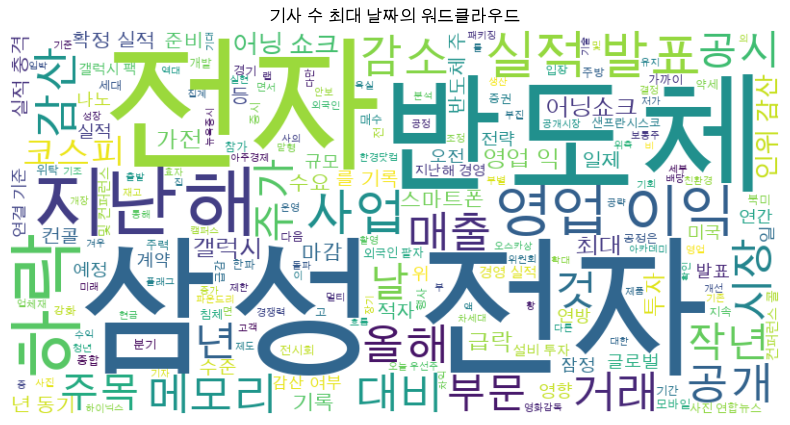

In [15]:
# 형태소 분석기
okt = Okt()

# 뉴스 원문만 추출하고 NaN제거
news_texts = most_articles_df.iloc[:, 1:40].apply(lambda row : ' '.join(row.dropna().astype(str)), axis=1)
all_text = ' '.join(news_texts)

# 형태소 분석 후 명사만 추출 (조사 등 제거)
nouns = okt.nouns(all_text)
filtered_text = ' '.join(nouns)

# 워드클라우드 생성
font_path = fm.findfont("Arial Unicode MS")
wordcloud = WordCloud(font_path=font_path, background_color='white', width=800, height=400).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("기사 수 최대 날짜의 워드클라우드")
plt.show()

#### 기사가 가장 많은 날의 뉴스 기사 TF-IDF 분석

In [16]:
# 뉴스 원문을 명사 기반으로 문서화
documents = []

for _, row in most_articles_df.iloc[:, 1:40].iterrows() :
    text = ' '.join(row.dropna().astype(str))   # NaN 제거
    nouns = okt.nouns(text)     # 명사만 추출
    documents.append(' '.join(nouns))

vectorizer = TfidfVectorizer(max_features=50)
tfidf_matrix = vectorizer.fit_transform(documents)

# 키워드 및 점수 추출
keywords = vectorizer.get_feature_names_out()
scores = tfidf_matrix.sum(axis=0).A1

sorted_items = sorted(zip(keywords, scores), key=lambda x : x[1], reverse=True)
for word, score in sorted_items[:20] :
    print(f"{word} : {score:.2f}")

전자 : 0.66
삼성 : 0.35
반도체 : 0.29
실적 : 0.24
영업 : 0.20
감산 : 0.18
지난해 : 0.17
발표 : 0.13
하락 : 0.13
이익 : 0.13
사업 : 0.09
갤럭시 : 0.09
기록 : 0.09
투자 : 0.09
감소 : 0.08
거래 : 0.07
공개 : 0.07
대비 : 0.07
매출 : 0.07
메모리 : 0.07


#### 부정, 중립, 긍정의 감성 분포

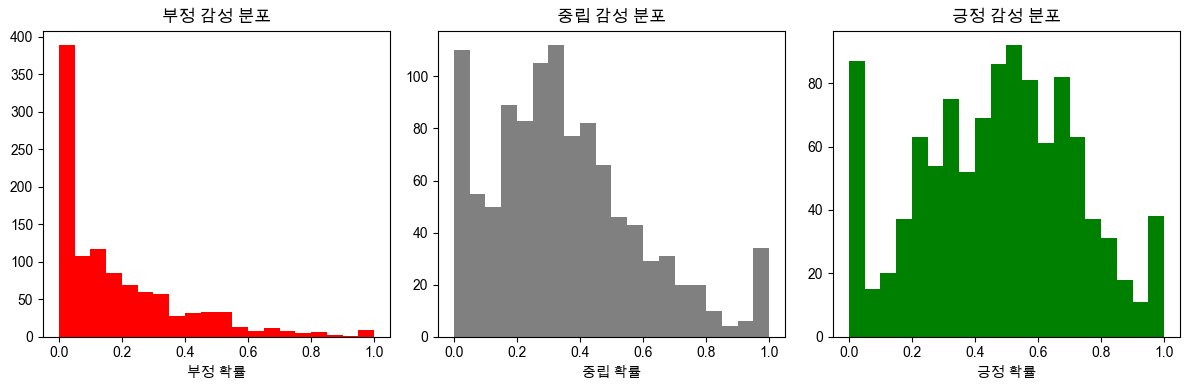

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df['avg_negative'].dropna(), bins=20, color='red')
plt.title("부정 감성 분포")
plt.xlabel("부정 확률")

plt.subplot(1, 3, 2)
plt.hist(df['avg_neutral'].dropna(), bins=20, color='gray')
plt.title("중립 감성 분포")
plt.xlabel("중립 확률")

plt.subplot(1, 3, 3)
plt.hist(df['avg_positive'].dropna(), bins=20, color='green')
plt.title("긍정 감성 분포")
plt.xlabel("긍정 확률")

plt.tight_layout()
plt.show()

#### 평균, 중앙값, 최대/최소, IQR
- news_count, avg_negative, avg_neutral, avg_positive, close, volume

In [18]:
features = ['news_count', 'avg_negative', 'avg_neutral', 'avg_positive', 'close', 'volume']

for feature in features :
    print(f"==============={feature} 기초 통계===============")

    mean = np.mean(df[f'{feature}'])
    median = np.median(df[f'{feature}'])
    maximum = np.max(df[f'{feature}'])
    minimum = np.min(df[f'{feature}'])
    des = df[f'{feature}'].describe()
    q1 = des['25%']
    q2 = des['50%']
    q3 = des['75%']

    if feature == 'news_count' :
        total_num = df['news_count'].count()
        print(f"news_count 총 개수 : {total_num}")

    if feature == 'close' :
        print(f"{feature} 평균값 : ₩{round(mean,2)}")
        print(f"{feature} 중앙값 : ₩{int(median)}")
        print(f"{feature} 최댓값 : ₩{int(maximum)}")
        print(f"{feature} 최솟값 : ₩{int(minimum)}")
        print(f"{feature} IQR(25%) : ₩{int(q1)}")
        print(f"{feature} IQR(50%) : ₩{int(q2)}")
        print(f"{feature} IQR(75%) : ₩{int(q3)}")
    else :
        print(f"{feature} 평균값 : {round(mean,2)}")
        print(f"{feature} 중앙값 : {median}")
        print(f"{feature} 최댓값 : {maximum}")
        print(f"{feature} 최솟값 : {minimum}")
        print(f"{feature} IQR(25%) : {q1}")
        print(f"{feature} IQR(50%) : {q2}")
        print(f"{feature} IQR(75%) : {q3}")

===============news_count 기초 통계===============
news_count 총 개수 : 1072
news_count 평균값 : 8.58
news_count 중앙값 : 8.0
news_count 최댓값 : 39
news_count 최솟값 : 0
news_count IQR(25%) : 5.0
news_count IQR(50%) : 8.0
news_count IQR(75%) : 11.0
===============avg_negative 기초 통계===============
avg_negative 평균값 : 0.18
avg_negative 중앙값 : 0.11505
avg_negative 최댓값 : 0.9998
avg_negative 최솟값 : 0.0
avg_negative IQR(25%) : 0.0060750000000000005
avg_negative IQR(50%) : 0.11505
avg_negative IQR(75%) : 0.26845
===============avg_neutral 기초 통계===============
avg_neutral 평균값 : 0.35
avg_neutral 중앙값 : 0.32365
avg_neutral 최댓값 : 1.0
avg_neutral 최솟값 : 0.0
avg_neutral IQR(25%) : 0.174375
avg_neutral IQR(50%) : 0.32365
avg_neutral IQR(75%) : 0.49025
===============avg_positive 기초 통계===============
avg_positive 평균값 : 0.47
avg_positive 중앙값 : 0.49595
avg_positive 최댓값 : 0.9999
avg_positive 최솟값 : 0.0
avg_positive IQR(25%) : 0.291225
avg_positive IQR(50%) : 0.49595
avg_positive IQR(75%) : 0.655825
===============close 기초 통계==

#### label별 0, 1 데이터 개수 및 비율

In [19]:
df['label'].value_counts()

label
0    597
1    475
Name: count, dtype: int64

label 0 개수 : 597
label 1 개수 : 475


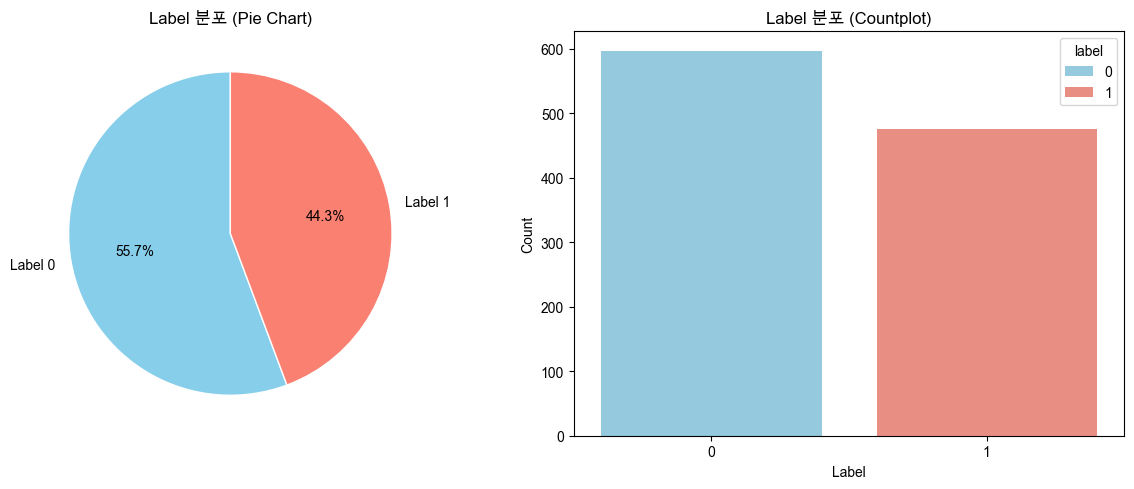

In [20]:
# 라벨별 개수 계산
label_counts = df['label'].value_counts().sort_index()
labels = ['Label 0', 'Label 1']
total = label_counts.sum()
label_ratios = {0: label_counts[0] / total * 100, 1: label_counts[1] / total * 100}

print(f"label 0 개수 : {label_counts[0]}")
print(f"label 1 개수 : {label_counts[1]}")

# 서브플롯 생성 (1행 2열)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 파이차트
ax1.pie(
    label_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'salmon'],
    wedgeprops={'edgecolor': 'white'}
)
ax1.set_title('Label 분포 (Pie Chart)')

# Countplot
sns.countplot(x='label', data=df, ax=ax2, hue=df['label'], palette=['skyblue', 'salmon'])

ax2.set_title('Label 분포 (Countplot)')
ax2.set_xlabel('Label')
ax2.set_ylabel('Count')

# 전체 레이아웃 정리
plt.tight_layout()
plt.show()

##### ⇒ ***label 0 클래스의 비중이 label 1 클래스 비중보다 약 1.25배 더 높다.***

#### 입력 데이터의 유효성 검증
- 감성 스코어 3개 합이 1이 되는지 확인

In [21]:
total_prob = 0

for i in range(len(df)) :
    total_prob += np.sum(df['avg_positive'][i]) + np.sum(df['avg_neutral'][i]) + np.sum(df['avg_negative'][i])

print(len(df), round(total_prob, 2))

1072 1072.0


- 감성 스코어는 평균값이라 소수점에서 차이가 약간 발생
##### ⇒ ***전체 데이터 개수와 감성 스코어 3개의 총 합이 일치***

# 2. 감성 분포 분석
#### **label==1인 경우에 avg_positive가 높을까?**
- 상승일과 하락일의 avg_negative, avg_neutral, avg_positive의 평균 비교

In [22]:
tmp_df2 = deepcopy(df)

tmp_df2 = tmp_df2.groupby('label')[['avg_negative', 'avg_neutral', 'avg_positive']]

# 확률값 총 합
tmp_df2.sum()

,avg_negative,avg_neutral,avg_positive
label,,,
0,111.9679,202.6139,282.4169
1,80.2183,171.4857,223.2969


In [23]:
# 확률값 평균
tmp_df2.mean()

,avg_negative,avg_neutral,avg_positive
label,,,
0,0.187551,0.339387,0.473060
1,0.168881,0.361023,0.470099


- label 0 (하락 or 유지) : avg_neutral의 비중이 높고, avg_negative보다 avg_positive가 더 높다.
- label 1 (상승) : avg_positive의 비중이 가장 높지만, avg_neutral의 비중과 큰 차이가 없다.
##### ⇒ ***avg_neutral의 비중이 label 0, 1 두 클래스에서 모두 높은 비중을 차지하고 있다.***

## 부정/중립/긍정 감성 분포의 시간 흐름에 따른 변화 추이
- 15일 이동평균을 적용해 그래프 간소화
- positive-negative 관계 파악

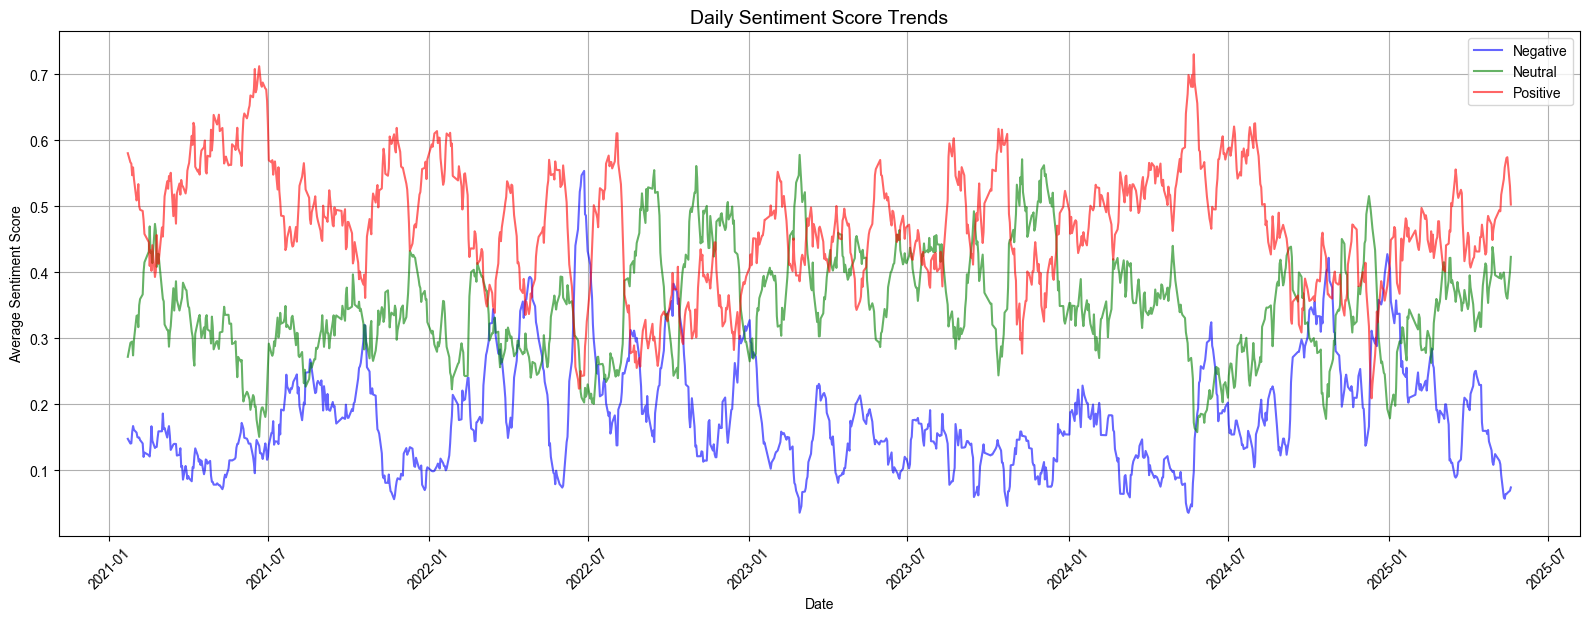

In [24]:
tmp_df1 = deepcopy(df)

# 날짜 컬럼을 datetime 형식으로 변환
tmp_df1['date'] = pd.to_datetime(tmp_df1['date'])

# 날짜 기준 정렬
tmp_df1 = tmp_df1.sort_values('date')

tmp_df1['neg_ma15'] = tmp_df1['avg_negative'].rolling(window=15).mean()
tmp_df1['neu_ma15'] = tmp_df1['avg_neutral'].rolling(window=15).mean()
tmp_df1['pos_ma15'] = tmp_df1['avg_positive'].rolling(window=15).mean()

# 시계열 선 그래프
plt.figure(figsize=(16,6))
plt.plot(tmp_df1['date'], tmp_df1['neg_ma15'], label='Negative', color='blue', alpha=0.6)
plt.plot(tmp_df1['date'], tmp_df1['neu_ma15'], label='Neutral', color='green', alpha=0.6)
plt.plot(tmp_df1['date'], tmp_df1['pos_ma15'], label='Positive', color='red', alpha=0.6)

# 시각화
plt.title("Daily Sentiment Score Trends", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

- 3개의 감성 점수와 close 변동 비교

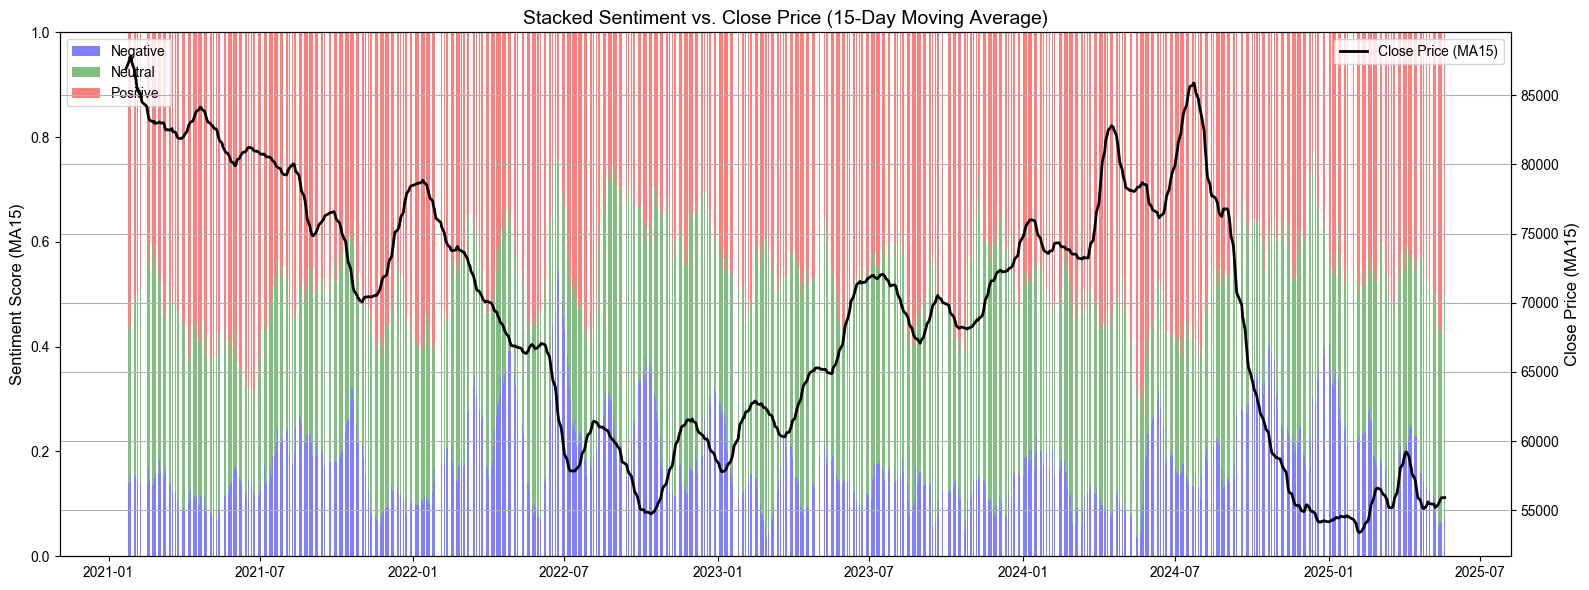

In [25]:
tmp_df1['close_ma15'] = tmp_df1['close'].rolling(window=15).mean()

# NaN이 없는 구간만 선택
plot_df = tmp_df1.dropna(subset=['neg_ma15', 'neu_ma15', 'pos_ma15', 'close_ma15'])

# 시각화 데이터 추출
x = plot_df['date']
neg = plot_df['neg_ma15']
neu = plot_df['neu_ma15']
pos = plot_df['pos_ma15']
close = plot_df['close_ma15']

# 시각화 시작
fig, ax1 = plt.subplots(figsize=(16, 6))

# Stacked Bar (감성 비중)
ax1.bar(x, neg, label='Negative', color='blue', alpha=0.5)
ax1.bar(x, neu, bottom=neg, label='Neutral', color='green', alpha=0.5)
ax1.bar(x, pos, bottom=neg + neu, label='Positive', color='red', alpha=0.5)

# 첫 번째 y축 라벨 및 범위
ax1.set_ylabel('Sentiment Score (MA15)', fontsize=12)
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')

# 두 번째 y축 (주가)
ax2 = ax1.twinx()
ax2.plot(x, close, label='Close Price (MA15)', color='black', linewidth=2)
ax2.set_ylabel('Close Price (MA15)', fontsize=12)
ax2.legend(loc='upper right')

# 전체 제목, 축 스타일
plt.title('Stacked Sentiment vs. Close Price (15-Day Moving Average)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()

plt.show()

#### `avg_positive` - `close` 시계열 라인플롯
- 동조성 여부 확인
- avg_positive와 close 스케일링 : MinMaxScaler

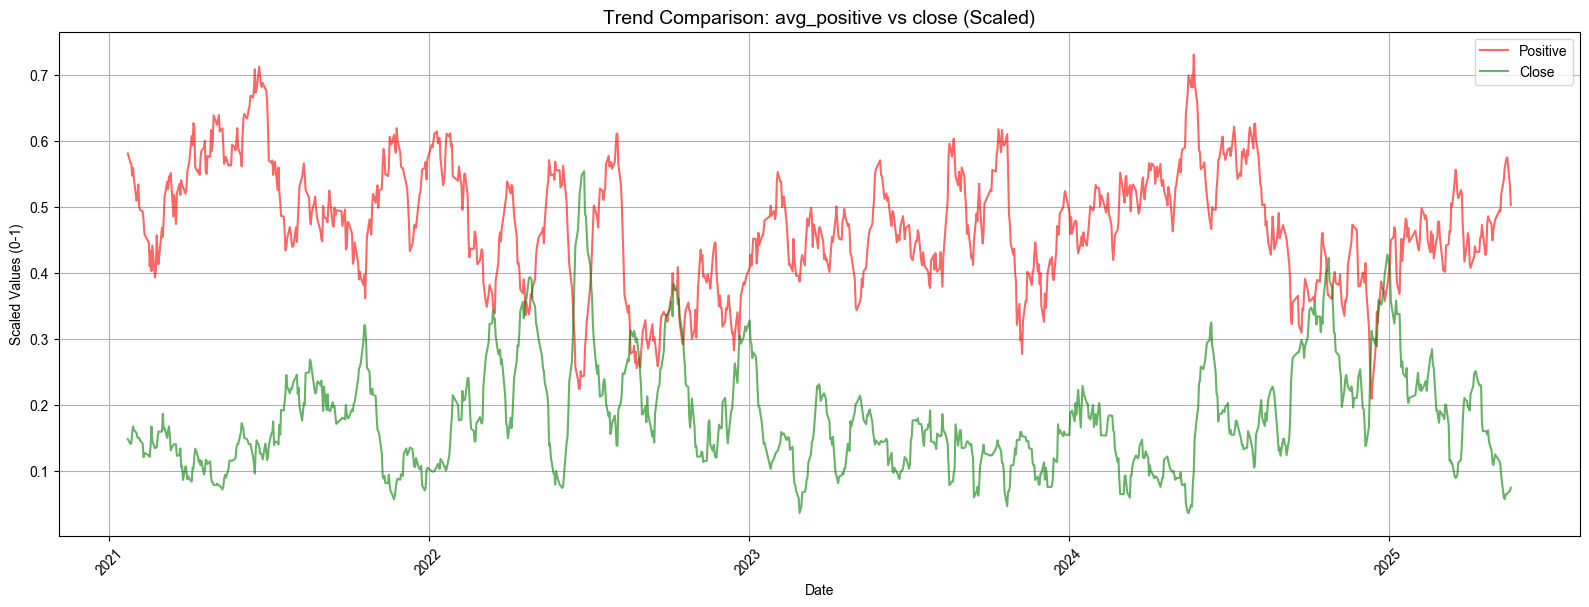

In [26]:
tmp_df3 = deepcopy(df)

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(tmp_df3[['avg_positive', 'avg_negative']])

tmp_df3['avg_positive_scaled'] = scaled_values[:, 0]
tmp_df3['close_scaled'] = scaled_values[:, 1]

tmp_df3['pos_ma15'] = tmp_df3['avg_positive_scaled'].rolling(window=15).mean()
tmp_df3['cls_ma15'] = tmp_df3['close_scaled'].rolling(window=15).mean()

# 시계열 선 그래프
plt.figure(figsize=(16,6))
plt.plot(tmp_df3['date'], tmp_df3['pos_ma15'], label='Positive', color='red', alpha=0.6)
plt.plot(tmp_df3['date'], tmp_df3['cls_ma15'], label='Close', color='green', alpha=0.6)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # 매년
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 연도만 텍스트로

# 시각화
plt.title('Trend Comparison: avg_positive vs close (Scaled)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Scaled Values (0-1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

#### label별 감성 점수
- label이 1일 때 `avg_positive` - `avg_negative`의 분포 vs 0일 때와 비교

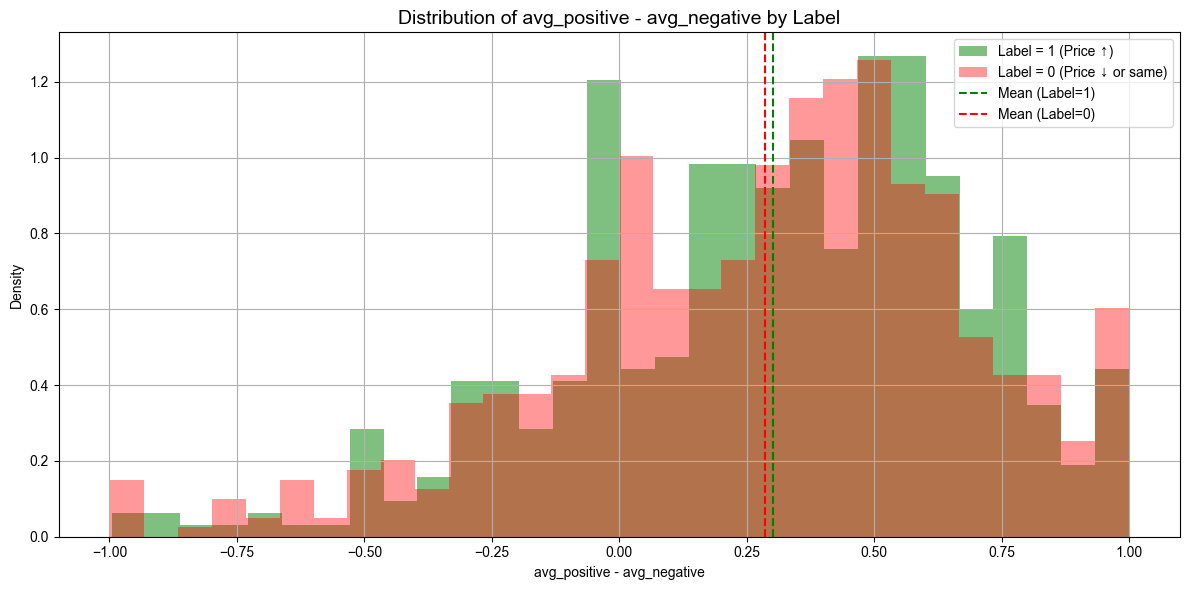

In [27]:
tmp_df5 = deepcopy(df)

# sentiment 차이 계산
tmp_df5['sentiment_diff'] = tmp_df5['avg_positive'] - tmp_df5['avg_negative']

# label 기준으로 분할
diff_up = tmp_df5[tmp_df5['label'] == 1]['sentiment_diff']
diff_down = tmp_df5[tmp_df5['label'] == 0]['sentiment_diff']

# 시각화 (히스토그램 + 밀도 추정)
plt.figure(figsize=(12, 6))
plt.hist(diff_up, bins=30, alpha=0.5, label='Label = 1 (Price ↑)', color='green', density=True)
plt.hist(diff_down, bins=30, alpha=0.4, label='Label = 0 (Price ↓ or same)', color='red', density=True)

plt.axvline(diff_up.mean(), color='green', linestyle='--', label='Mean (Label=1)')
plt.axvline(diff_down.mean(), color='red', linestyle='--', label='Mean (Label=0)')

plt.title('Distribution of avg_positive - avg_negative by Label', fontsize=14)
plt.xlabel('avg_positive - avg_negative')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- x축 : avg_positive - avg_negative (긍정 감성 점수에서 부정 감성 점수를 뺀 값)
- y축 : 확률 밀도 (densitive=True이므로 정규화된 값)
- 두 집단
    - 초록 : label = 1 (다음날 주가 상승)
    - 빨강 : label = 0 (다음날 주가 하락 or 유지)
- 점선
    - 초록 : 상승일의 평균값
    - 빨강 : 하락/유지일의 평균값

##### 1. label=1의 평균이 label=0의 평균보다 오른쪽에 위치
- 상승한 날의 avg_positive - avg_negative 평균이 더 크다
- 즉, **긍정 감성이 부정 감성보다 더 강했던 날일수록 주가가 오를 확률이 높았다**는 경향
##### 2. 분포 형태 해석
- label=1 (초록)
    - 전반적으로 0.25 ~ 0.6 부근에 밀도가 높음
    - 일부는 0보다 작지만, 대부분이 긍정이 우세한 구간에 있음
- label=0 (빨강)
    - 0 이하의 값이 상대적(초록 대비)으로 더 많이 분포
    - 전체적으로 좌우 분산이 크고, 중앙값이 더 왼쪽에 치우침
- 즉, **상승하지 않은 날은 긍정이 우세하지 않거나 오히려 부정 감성이 더 많은 날일 확률이 높았음**

# 3. 상관 분석
- news_count, avg_negative, avg_neutral, avg_positive, open, high, low, close, volume, label
- 분석 포인트
    - label과 연관이 높은 감성 지표 확인
    - volume ↔ news_count의 관계
    - avg_negative ↔ avg_positive 관계

In [29]:
tmp_df6 = deepcopy(df)

tmp_df6 = tmp_df6[['news_count', 'avg_negative', 'avg_neutral', 'avg_positive', 'open', 'high', 'low', 'close', 'volume']]

corr_df = tmp_df6.corr()

corr_df

,news_count,avg_negative,avg_neutral,avg_positive,open,high,low,close,volume
news_count,1.000000,0.051754,-0.173959,0.122700,0.079413,0.095770,0.077935,0.090291,0.303728
avg_negative,0.051754,1.000000,-0.359286,-0.469458,-0.164681,-0.168178,-0.172002,-0.174855,0.160578
avg_neutral,-0.173959,-0.359286,1.000000,-0.655328,-0.074008,-0.075099,-0.071798,-0.071613,-0.112999
avg_positive,0.122700,-0.469458,-0.655328,1.000000,0.203318,0.207180,0.207151,0.209287,-0.023061
open,0.079413,-0.164681,-0.074008,0.203318,1.000000,0.997742,0.998355,0.995834,0.120821
high,0.095770,-0.168178,-0.075099,0.207180,0.997742,1.000000,0.997538,0.998117,0.151007
low,0.077935,-0.172002,-0.071798,0.207151,0.998355,0.997538,1.000000,0.998113,0.105610
close,0.090291,-0.174855,-0.071613,0.209287,0.995834,0.998117,0.998113,1.000000,0.127858
volume,0.303728,0.160578,-0.112999,-0.023061,0.120821,0.151007,0.105610,0.127858,1.000000


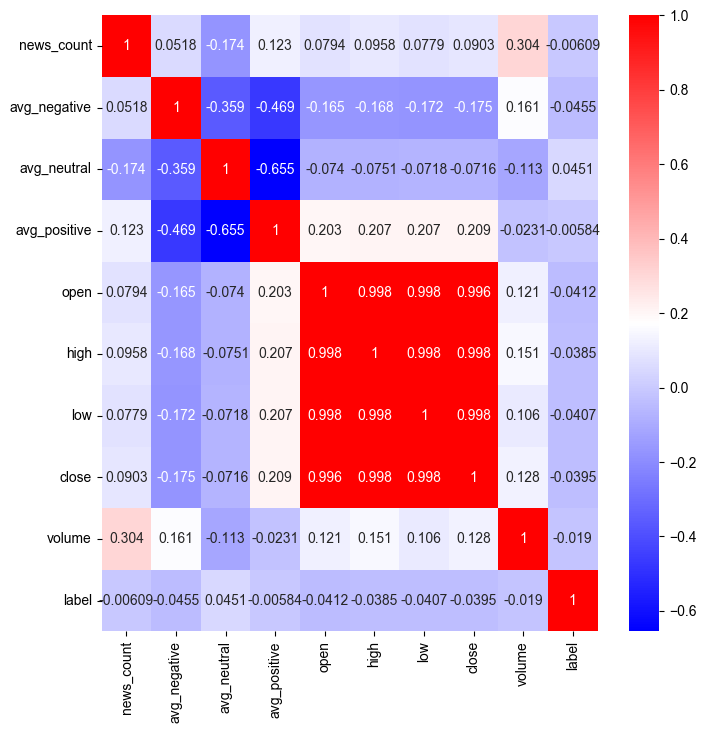

In [53]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_df, annot=True, fmt='.3g', cmap='bwr')
plt.show()

1. label과 가장 연관이 높은 feature : news_count
    - 가장 높은 상관계수값마저도 0.14로 크게 영향이 없다
    - 감성 점수는 avg_positive, avg_neutral, avg_negative순으로 연관성이 높았으며, 모두 0.1 아래 수준으로 매우 낮다.
    - **단순 상관으로는 예측력이 낮다.**


2. volume과 news_count는 0.21의 상관계수


3. avg_negative는 avg_positive와 음의 상관계수를 가지고 있으며, close와도 음의 상관계수를 갖는다.
    - **부정 뉴스가 많아질수록 중립/긍정 뉴스가 줄고, 주가는 약간 하락 경향을 보인다.**


4. avg_neutral은 avg_positive와 -0.721이라는 매우 강한 음의 상관관계를 보인다.
    - **중립 뉴스가 많아질수록 긍정 뉴스는 적다. 주가와의 상관은 거의 없다.**


5. avg_positive는 가격지표들과 소폭 양의 상관관계를 보인다.
    - **긍정 감성이 있는 경우 평균적으로 주가는 상승하는 경향이 있다.**


6. news_count는 가격지표와의 상관은 약하지만, avg_neutral, avg_positive와의 상관관계가 높다.
    - **뉴스 개수가 많을수록 중립, 긍정에 대한 감성 표현이 더 뚜렷한 경우가 있다.**

    
7. 주가 데이터(open, high, low, close)는 서로 굉장히 높은 상관계수를 갖는다. 

# 4. 뉴스 원문 활용 텍스트 기반 인사이트 검색

- 워드 클라우드

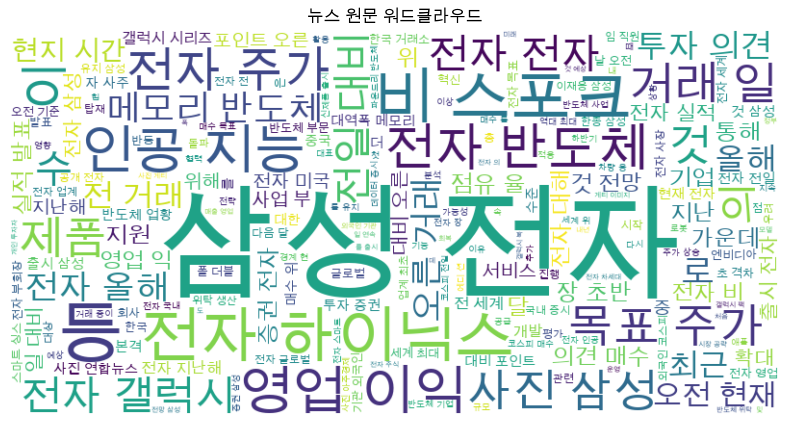

In [30]:
# 형태소 분석기
okt = Okt()

# 뉴스 원문만 추출하고 NaN제거
news_texts = df.iloc[:, 1:40].apply(lambda row : ' '.join(row.dropna().astype(str)), axis=1)
all_text = ' '.join(news_texts)

# 형태소 분석 후 명사만 추출 (조사 등 제거)
nouns = okt.nouns(all_text)
filtered_text = ' '.join(nouns)

# 워드클라우드 생성
font_path = fm.findfont("Arial Unicode MS")
wordcloud = WordCloud(font_path=font_path, background_color='white', width=800, height=400).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("뉴스 원문 워드클라우드")
plt.show()

이상적으로 변화가 큰 날짜들:
[Timestamp('2021-01-02 00:00:00'), Timestamp('2021-02-20 00:00:00'), Timestamp('2021-02-21 00:00:00'), Timestamp('2021-03-28 00:00:00'), Timestamp('2022-02-23 00:00:00'), Timestamp('2022-05-29 00:00:00'), Timestamp('2022-07-24 00:00:00'), Timestamp('2022-10-09 00:00:00'), Timestamp('2023-02-22 00:00:00'), Timestamp('2023-05-13 00:00:00'), Timestamp('2023-07-23 00:00:00'), Timestamp('2023-08-11 00:00:00'), Timestamp('2023-08-12 00:00:00'), Timestamp('2023-08-20 00:00:00'), Timestamp('2023-09-09 00:00:00'), Timestamp('2023-09-28 00:00:00'), Timestamp('2023-10-14 00:00:00'), Timestamp('2023-10-15 00:00:00'), Timestamp('2023-11-05 00:00:00'), Timestamp('2023-12-02 00:00:00'), Timestamp('2023-12-09 00:00:00'), Timestamp('2024-02-04 00:00:00'), Timestamp('2024-02-18 00:00:00'), Timestamp('2024-05-18 00:00:00'), Timestamp('2024-07-27 00:00:00'), Timestamp('2024-09-15 00:00:00'), Timestamp('2024-09-30 00:00:00'), Timestamp('2024-12-08 00:00:00'), Timestamp('2024-12-09 00:00:00

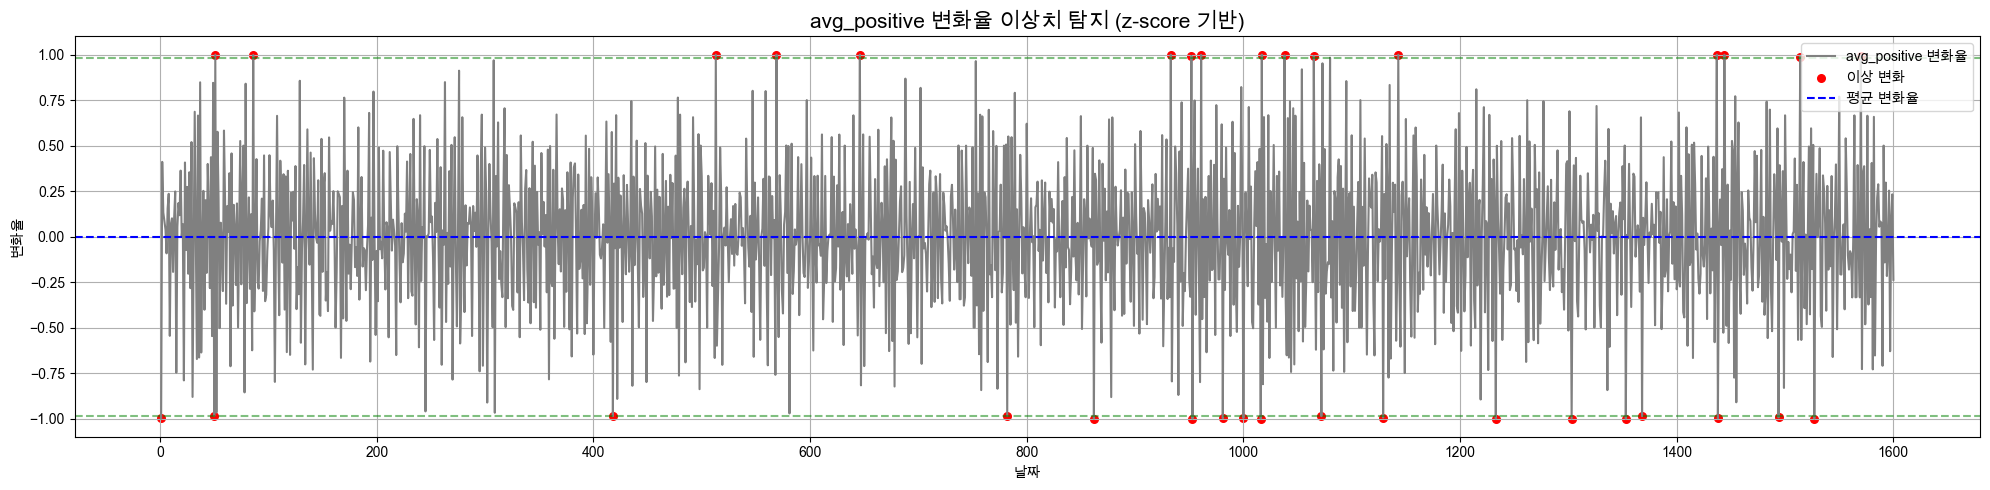

In [ ]:
tmp_df10 = deepcopy(df)

# 1. 결측치 처리
tmp_df10['avg_positive'] = tmp_df10['avg_positive'].fillna(0)

# 2. 1차 차분 → 변화율 계산
tmp_df10['pos_diff'] = tmp_df10['avg_positive'].diff()

# 3. 평균과 표준편차
mean_diff = tmp_df10['pos_diff'].mean()
std_diff = tmp_df10['pos_diff'].std()

# 4. Z-score 계산
tmp_df10['z_score'] = (tmp_df10['pos_diff'] - mean_diff) / std_diff

# 5. 임계값 설정 (|z| > 2.5 → 통상 이상치로 간주)
threshold = 2.5
tmp_df10['is_outlier'] = tmp_df10['z_score'].abs() > threshold

# 6. 이상 변화율 발생 날짜 출력
outlier_dates = tmp_df10[tmp_df10['is_outlier']].index

outlier_dates_list = list(tmp_df10.iloc[outlier_dates]['date'])
print("이상적으로 변화가 큰 날짜들:")
print(outlier_dates_list)

# 7. 시각화
plt.figure(figsize=(20, 5))
plt.plot(tmp_df10.index, tmp_df10['pos_diff'], label='avg_positive 변화율', color='gray')
plt.scatter(tmp_df10[tmp_df10['is_outlier']].index, tmp_df10[tmp_df10['is_outlier']]['pos_diff'],
            color='red', label='이상 변화', s=30)
plt.axhline(mean_diff, color='blue', linestyle='--', label='평균 변화율')
plt.axhline(mean_diff + threshold * std_diff, color='green', linestyle='--', alpha=0.5)
plt.axhline(mean_diff - threshold * std_diff, color='green', linestyle='--', alpha=0.5)
plt.title('avg_positive 변화율 이상치 탐지 (z-score 기반)', fontsize=15)
plt.xlabel('날짜')
plt.ylabel('변화율')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- TF-IDF 키워드 추출

In [31]:
# 형태소 분석기
okt = Okt()

# 뉴스 원문 텍스트 → 명사 기반 문서화
documents = []
for _, row in df.iloc[:, 1:40].iterrows():
    text = ' '.join(row.dropna().astype(str))  # NaN 제거 + 문자열 결합
    nouns = okt.nouns(text)                    # 명사 추출
    documents.append(' '.join(nouns))          # 공백으로 다시 결합

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=50)
tfidf_matrix = vectorizer.fit_transform(documents)

# 키워드와 점수 추출
keywords = vectorizer.get_feature_names_out()
scores = tfidf_matrix.sum(axis=0).A1

# DataFrame으로 변환 후 상위 20개 추출
tfidf_df = pd.DataFrame({'keyword': keywords, 'score': scores})
tfidf_df = tfidf_df.sort_values(by='score', ascending=False).head(20)

# 회사명과 빈도수를 함께 보여줄 텍스트 생성
tfidf_df['label'] = tfidf_df['keyword'] + ' (' + tfidf_df['score'].astype(str) + ')'

# 트리맵 시각화
plt.figure(figsize=(12, 8))
fig = px.treemap(tfidf_df, 
                 path=['label'], # 각 사각형의 이름
                 values='score', # 크기 기준
                 color='score', # 색상 기준
                 color_continuous_scale='RdBu',  # 색상 스케일 설정
                )
fig.show()

<Figure size 1200x800 with 0 Axes>

- 기업명 단어 등장 빈도수 분석

In [32]:
tmp_df7 = deepcopy(df)

# 형태소 분석기 초기화
okt = Okt()

# 기업명 후보 추출용 변수 초기화
all_nouns = []
entity_counts = []

# 불용어/제외어 (분석 대상 등)
stopwords = ['삼성', '삼성전자']

# 상장기업 리스트 (샘플)
known_companies = {'네이버', '카카오', 'LG전자', '현대자동차', '기아', '롯데', 'SK하이닉스', '하이닉스', '한화', '코스피', '엔비디아', 'nvidia', 'NVIDIA', 'tsmc', 'TSMC'}

# 기업명 후보 추출 루프
for row in tmp_df7.iloc[:, 1:40].fillna('').astype(str).values:
    text = ' '.join(row)
    nouns = okt.nouns(text)

    filtered = [n for n in nouns if len(n) > 1 and n not in stopwords]

    all_nouns.extend(filtered)
    matched = [n for n in filtered if n in known_companies]

    entity_counts.append(len(matched))

# 기업명 카운트: known_companies에 있는 항목만 필터링
known_entity_counts = Counter([n for n in all_nouns if n in known_companies])

# DataFrame에 반영
tmp_df7['other_org_count'] = entity_counts

# 출력
print("상위 기업명 후보 (known_companies 기준):")
for word, count in known_entity_counts.most_common():
    print(f"{word}: {count}")

# 트리맵 시각화
# Counter 객체 → DataFrame 변환
company_df = pd.DataFrame(known_entity_counts.items(), columns=['company', 'score'])

# 회사명과 빈도수를 함께 보여줄 텍스트 생성
company_df['label'] = company_df['company'] + ' (' + company_df['score'].astype(str) + ')'

# 트리맵 시각화 (Plotly)
fig = px.treemap(
    company_df,
    path=['label'],       # 각 사각형의 이름
    values='score',         # 크기 기준
    color='score',          # 색상 기준
    color_continuous_scale='RdBu',  # 색상 스케일 설정
    title='뉴스 기사에 등장한 주요 기업명 빈도수 (Treemap)'
)

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    uniformtext=dict(minsize=14, mode='hide')
)

fig.show()

상위 기업명 후보 (known_companies 기준):
하이닉스: 1301
코스피: 1246
엔비디아: 336
네이버: 125
카카오: 89
기아: 73
한화: 53
롯데: 45


- 상승일/하락일 기사의 뉴스 기사 상위 키워드 분석
    - 상승/하락일 기반 2-gram TF-IDF 키워드 분석 -> 상승/하락 문맥의 감정 차이 분석

In [33]:
oct = Okt()

def prepare_documents(sub_df):
    documents = []
    for _, row in sub_df.iloc[:, 1:40].iterrows():
        text = ' '.join(row.dropna().astype(str))
        nouns = okt.nouns(text)
        documents.append(' '.join(nouns))
    return documents

# 상승일/하락일 분할
df_rise = df[df['label'] == 1]
df_fall = df[df['label'] == 0]

rise_docs = prepare_documents(df_rise)
fall_docs = prepare_documents(df_fall)

# 2-gram 기반 벡터라이저 설정
vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=30)

# 상승일 분석
rise_matrix = vectorizer.fit_transform(rise_docs)
rise_keywords = vectorizer.get_feature_names_out()
rise_scores = rise_matrix.sum(axis=0).A1
rise_result = sorted(zip(rise_keywords, rise_scores), key=lambda x: x[1], reverse=True)

print("상승일 주요 2-gram:")
for word, score in rise_result:
    print(f"{word}: {score:.2f}")

# 하락일 분석
vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=30)
fall_matrix = vectorizer.fit_transform(fall_docs)
fall_keywords = vectorizer.get_feature_names_out()
fall_scores = fall_matrix.sum(axis=0).A1
fall_result = sorted(zip(fall_keywords, fall_scores), key=lambda x: x[1], reverse=True)

print("\n하락/유지일 주요 2-gram:")
for word, score in fall_result:
    print(f"{word}: {score:.2f}")

상승일 주요 2-gram:
삼성 전자: 340.89
전자 하이닉스: 46.49
인공 지능: 32.77
전자 반도체: 31.39
목표 주가: 29.75
전자 주가: 28.33
사진 삼성: 27.01
전자 전자: 25.88
전자 갤럭시: 24.45
영업 이익: 23.17
메모리 반도체: 21.86
현지 시간: 21.78
전일 대비: 21.30
투자 의견: 20.63
갤럭시 시리즈: 20.26
의견 매수: 20.10
출시 전자: 19.64
전자 대해: 19.13
전자 미국: 19.07
오른 거래: 18.79
전자 올해: 18.74
증권 전자: 18.50
전자 스포크: 18.21
전자 삼성: 17.66
오전 현재: 16.72
전자 부회장: 16.02
포인트 오른: 15.30
전자 사장: 13.42
대비 오른: 13.08
전자 실적: 12.85

하락/유지일 주요 2-gram:
삼성 전자: 434.19
전자 하이닉스: 58.02
인공 지능: 43.07
전자 반도체: 37.92
전자 갤럭시: 37.44
전자 주가: 34.88
전자 전자: 30.97
사진 삼성: 30.78
목표 주가: 30.56
영업 이익: 30.30
전일 대비: 27.02
현지 시간: 26.40
오른 거래: 25.05
전자 스포크: 24.99
전자 올해: 24.67
전자 삼성: 23.70
출시 전자: 23.27
메모리 반도체: 23.05
오전 현재: 22.03
투자 의견: 22.00
거래 대비: 21.85
대비 오른: 20.89
증권 전자: 20.89
전자 대해: 20.77
의견 매수: 20.27
갤럭시 시리즈: 19.43
실적 발표: 19.29
전자 지난해: 16.97
전자 실적: 16.49
대역폭 메모리: 16.10


- 상승/하락일 기반 감성어 빈도 분석
    - 감성어 필터 사전 정의

In [34]:
# 감성어 사전 정의
positive_words = ['상승', '호조', '기대', '강세', '호재', '개선', '돌파', '급등', '호황', '확대']
negative_words = ['하락', '우려', '약세', '감소', '둔화', '실망', '위기', '축소', '급락', '불안']

# 뉴스 문서 전처리 함수
def prepare_documents(sub_df):
    documents = []
    for _, row in sub_df.iloc[:, 1:40].iterrows():
        text = ' '.join(row.dropna().astype(str))
        documents.append(text)
    return documents

rise_docs = prepare_documents(df[df['label'] == 1])
fall_docs = prepare_documents(df[df['label'] == 0])

# 감성어 빈도 세기 함수
def count_sentiment_terms(docs, word_list):
    return sum(text.count(word) for text in docs for word in word_list)

print("상승일 감성어 등장 빈도")
print("긍정 단어 빈도:", count_sentiment_terms(rise_docs, positive_words))
print("부정 단어 빈도:", count_sentiment_terms(rise_docs, negative_words))

print("\n하락/유지일 감성어 등장 빈도")
print("긍정 단어 빈도:", count_sentiment_terms(fall_docs, positive_words))
print("부정 단어 빈도:", count_sentiment_terms(fall_docs, negative_words))

상승일 감성어 등장 빈도
긍정 단어 빈도: 1740
부정 단어 빈도: 877

하락/유지일 감성어 등장 빈도
긍정 단어 빈도: 1999
부정 단어 빈도: 1312


# 5. 주가 데이터 시계열 분해 및 변화 탐지

#### 1. 시계열 분해 (Time Series Decomposition)
1) **추세 (Trend)**
- 장기적인 방향성
- 시간이 지남에 따라 장기적으로 데이터가 상승하거나 하락하는 경향을 보여줌

2) **계절성(Seasonality)**
- 일정 주기로 반복되는 패턴 ex) 분기별 실적 발표에 따른 주가 변동
- 주식시장에서는 월말 효과, 배당 발표, 분기 실적 등과 관련 있음

3) **잔차(Residual / Noise)**
- 추세나 계절성으로 설명되지 않는 비정형적인 변동. 즉, 예상 밖의 움직임 ex) 갑작스러운 뉴스 이슈, 예기치 못한 시장 반응 

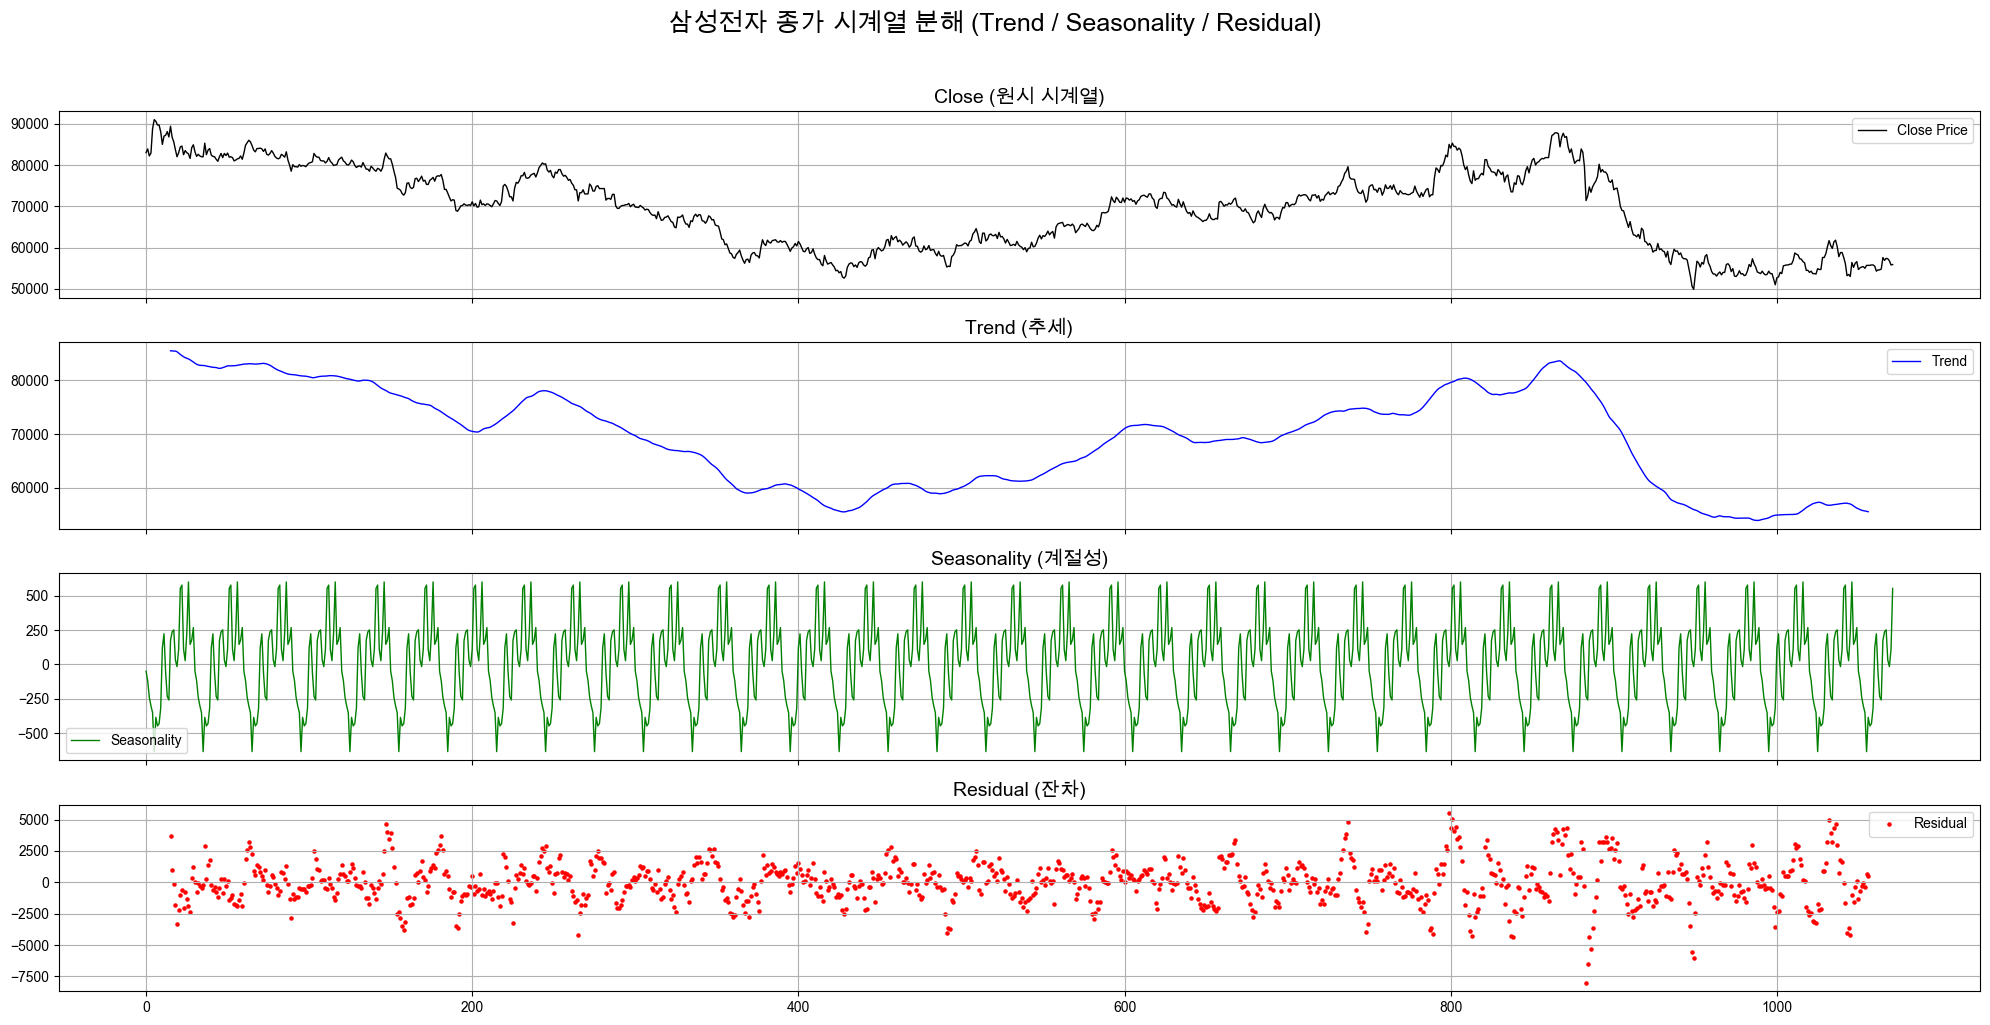

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

tmp_df9 = deepcopy(df)

# 시계열 분해
result = seasonal_decompose(tmp_df9['close'], model='additive', period=30)  # 월 단위 계절성을 가정

# 시각화
fig, axs = plt.subplots(4, 1, figsize=(20, 10), sharex=True)

axs[0].plot(result.observed, label='Close Price', color='black', linewidth=1)
axs[0].set_title('Close (원시 시계열)', fontsize=14)

axs[1].plot(result.trend, label='Trend', color='blue', linewidth=1)
axs[1].set_title('Trend (추세)', fontsize=14)

axs[2].plot(result.seasonal, label='Seasonality', color='green', linewidth=1)
axs[2].set_title('Seasonality (계절성)', fontsize=14)

axs[3].scatter(result.resid.index, result.resid, label='Residual', color='red', s=5)
axs[3].set_title('Residual (잔차)', fontsize=14)

for ax in axs:
    ax.grid(True)
    ax.legend()

fig.suptitle('삼성전자 종가 시계열 분해 (Trend / Seasonality / Residual)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# 각 성분 추출
trend = result.trend
seasonal = result.seasonal
resid = result.resid

##### (1) Close (원시 시계열)
- 단기적으로 오르고 내리는 작은 파동이 반복됨
- 중간쯤부터는 큰 폭의 하락과 상승이 번갈아 나타나는 복합적인 흐름을 보여줌
##### (2) Trend (추세)
- 초반엔 8만 원대에서 시작해 서서히 하락
- 중반부에 잠시 반등
- 다시 하락하여 현재는 6만 원대 수준
    - 1~2년간 뉴스가 계속 긍정적이고 실적이 좋다면 상승 추세
    - 글로벌 반도체 수요 감소, 수출 규제 등 악재가 누적되면 하락 추세
##### (3) Seansonality (계절성)
- 주기가 매우 뚜렷한 반복 형태로 나타남 (30일 주기)
- 고점과 저점의 간격이 일정한 파형 형태 : 주가가 반복되는 패턴 때문에 평균에서 얼마만큼 위/아래로 벗어나는가
- 양수 -> 그날은 평균보다 높게 움직이는 경향이 있음 (y=+200 : 주기적 패턴 때문에 종가가 평균보다 200원 높아질 경향이 있는 날)
- 음수 -> 그날은 평균보다 낮게 움직이는 경향이 있음 (y=-150 : 주기적 패턴 때문에 종가가 평균보다 150원 낮아질 경향이 있는 날)
    - 예시 계절성 : "삼성전자는 실적 발표 전날에 주가가 오른다."
##### (4) Residual (잔차)
- 잔차 = 원시 close값 - (추세 + 계절성)
- y축 절댓값이 클수록, 해당 날짜의 종가는 예측보다 크게 벗어난 것
- 대부분의 점이 0에 몰려있음
- 특정 지점에서 큰 폭으로 튀는 점들(outlier) 존재
    - 갑작스러운 뉴스(반도체 공급 차질, 갑작스러운 CEO 교체 등)로 인한 주가 급변 -> 잔차로 표햔됨

#### 2. avg_positive 시계열에서 변화율이 급격히 달라진 지점 탐색
- z-score 활용
    - z-score : 하나의 데이터가 전체 평균에서 얼마나 떨어져 있는지를 표준편차 단위로 표현한 값
    - z-score가 클수록 평균에서 멀리 떨어진 값
- 평균과 표준편차를 기준으로 변화율이 비정상적으로 큰 날을 포착

이상적으로 변화가 큰 날짜들:
[Timestamp('2021-02-19 00:00:00'), Timestamp('2021-02-22 00:00:00'), Timestamp('2021-09-03 00:00:00'), Timestamp('2021-11-05 00:00:00'), Timestamp('2022-02-23 00:00:00'), Timestamp('2022-08-05 00:00:00'), Timestamp('2022-11-10 00:00:00'), Timestamp('2022-11-21 00:00:00'), Timestamp('2023-02-22 00:00:00'), Timestamp('2023-08-11 00:00:00'), Timestamp('2023-09-11 00:00:00'), Timestamp('2023-09-26 00:00:00'), Timestamp('2023-11-21 00:00:00'), Timestamp('2024-08-29 00:00:00')]


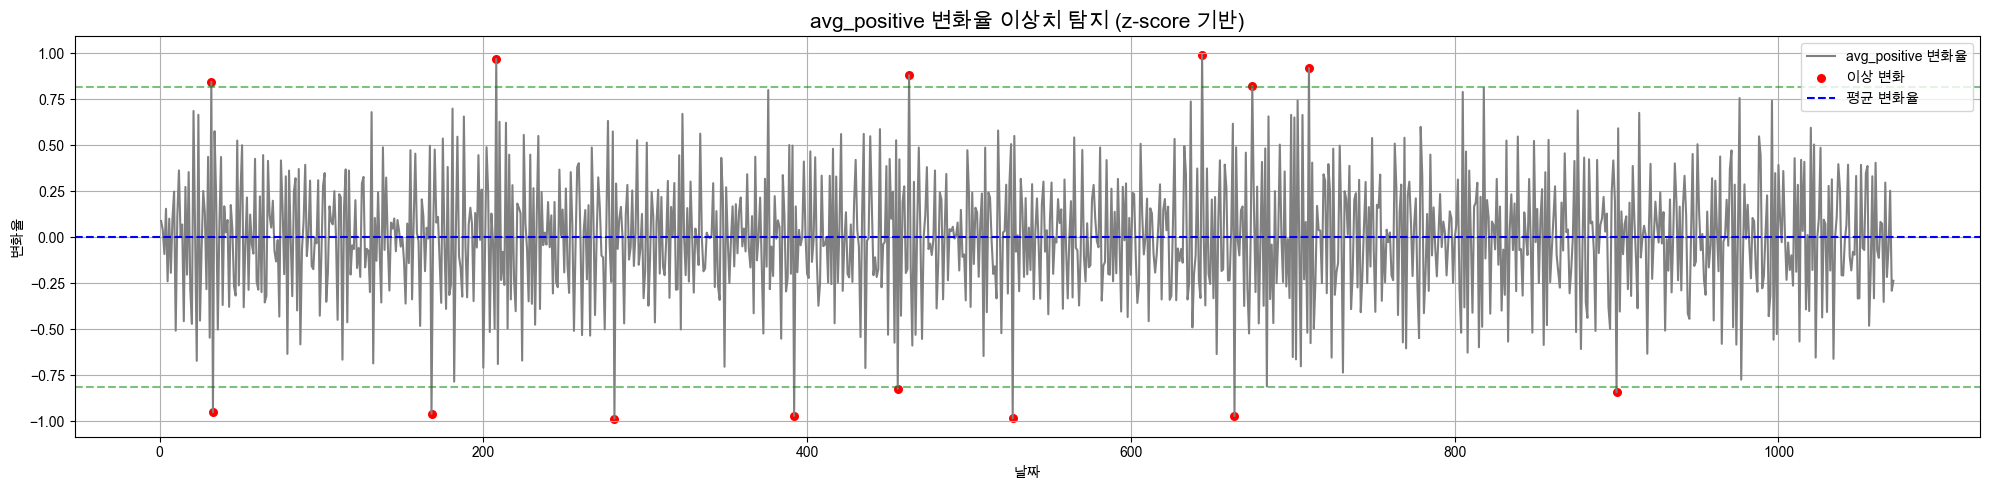

In [36]:
tmp_df10 = deepcopy(df)

# 1. 결측치 처리
tmp_df10['avg_positive'] = tmp_df10['avg_positive'].fillna(0)

# 2. 1차 차분 → 변화율 계산
tmp_df10['pos_diff'] = tmp_df10['avg_positive'].diff()

# 3. 평균과 표준편차
mean_diff = tmp_df10['pos_diff'].mean()
std_diff = tmp_df10['pos_diff'].std()

# 4. Z-score 계산
tmp_df10['z_score'] = (tmp_df10['pos_diff'] - mean_diff) / std_diff

# 5. 임계값 설정 (|z| > 2.5 → 통상 이상치로 간주)
threshold = 2.5
tmp_df10['is_outlier'] = tmp_df10['z_score'].abs() > threshold

# 6. 이상 변화율 발생 날짜 출력
outlier_dates = tmp_df10[tmp_df10['is_outlier']].index

outlier_dates_list = list(tmp_df10.iloc[outlier_dates]['date'])
print("이상적으로 변화가 큰 날짜들:")
print(outlier_dates_list)

# 7. 시각화
plt.figure(figsize=(20, 5))
plt.plot(tmp_df10.index, tmp_df10['pos_diff'], label='avg_positive 변화율', color='gray')
plt.scatter(tmp_df10[tmp_df10['is_outlier']].index, tmp_df10[tmp_df10['is_outlier']]['pos_diff'],
            color='red', label='이상 변화', s=30)
plt.axhline(mean_diff, color='blue', linestyle='--', label='평균 변화율')
plt.axhline(mean_diff + threshold * std_diff, color='green', linestyle='--', alpha=0.5)
plt.axhline(mean_diff - threshold * std_diff, color='green', linestyle='--', alpha=0.5)
plt.title('avg_positive 변화율 이상치 탐지 (z-score 기반)', fontsize=15)
plt.xlabel('날짜')
plt.ylabel('변화율')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- 이상치 기준 : z-score ≥ 2.5 또는 ≤ -2.5
    - 정규분포 상위/하위 0.6% 정도 되는 극단적인 값
    - 실제로는 전체 중 약 1~2% 미만의 데이터만 이상치로 탐지됨

- 회색선 : avg_positive의 일일 변화율
- 빨간점 : ±2.5σ 이상 벗어난 이상치 날짜 = 전날에 비해 감성 점수가 급격히 변했음
- 파란 점선 : 평균 변화율 (대부분 0 근처)
- 초록 점선 : ±2.5σ 경계선 -> 이 선을 넘으면 이상치로 간주

##### 변화율이 급격한 날짜의 뉴스 원문 분석

In [37]:
# 뉴스 본문 컬럼만 추출
news_cols = [col for col in tmp_df10.columns if str(col).isdigit()]

# 이상치 날짜 datetime 형변환
outlier_dates_dt = pd.to_datetime(outlier_dates_list)

# 이상치 날짜 ±1일 수집
window = 1
analyzed_news = {}

for date in outlier_dates_dt:
    start = date - timedelta(days=window)
    end = date + timedelta(days=window)

    # 'date' 컬럼을 기준으로 필터링
    mask = (pd.to_datetime(tmp_df10['date']) >= start) & (pd.to_datetime(tmp_df10['date']) <= end)
    news_window = tmp_df10.loc[mask, news_cols]

    # 뉴스 본문 추출 (빈 셀 제거)
    news_texts = news_window.values.flatten()
    news_texts = [text for text in news_texts if isinstance(text, str) and text.strip() != '']

    # 해당일의 pos_diff, close, label 값
    pos_diff = tmp_df10[tmp_df10['date'] == date.strftime('%Y-%m-%d')]['pos_diff'].item()
    close = tmp_df10[tmp_df10['date'] == date.strftime('%Y-%m-%d')]['close'].item()
    label = tmp_df10[tmp_df10['date'] == date.strftime('%Y-%m-%d')]['label'].item()

    analyzed_news[date.strftime('%Y-%m-%d')] = {'news_texts' : news_texts,
                                                'pos_diff' : pos_diff,
                                                'close' : close,
                                                'label' : label}

# 간단 확인
for date, data in analyzed_news.items():
    print(f"\n{date} : avg_positive 변화량 = {data['pos_diff']}, 종가(close) = {data['close']}, 다음날 등락 : {data['label']}, 전후 뉴스 요약 ({len(data)}건):")
    for i, text in enumerate(data['news_texts'][:3]):    # 상위 3개만 출력(단순 앞에서 3개만 보여줌)
        print(f" - 뉴스 {i+1}: {text[:100]}...")


2021-02-19 : avg_positive 변화량 = 0.845, 종가(close) = 82600.0, 다음날 등락 : 0, 전후 뉴스 요약 (4건):
 - 뉴스 1: 삼성전자 사내이사 5인, 지난해 연봉 평균 66억원 ||| 삼성전자의 주요 경영진이 지난해 60억원대에 달하는 연봉을 받은 것으로 나타났다. 18일 삼성전자가 금융위원회, 한국거래...
 - 뉴스 2: 삼성전자, 작년 등기이사 보수총액 337억원…전년 대비 2배로 늘어 ||| 삼성전자 주요 경영진은 작년에 지난 2019년보다 2배 가량의 연봉을 받은 것으로 나타났다. 18일 금융...
 - 뉴스 3: 툴젠, 삼성전자 상무 출신 특허전문가 김유리 변리사 영입 ||| 툴젠은 특허 전문가인 김유리 변리사·미국 변호사(사진)를 최고법률책임자(CLO)로 영입했다고 18일 밝혔다. 김유리...

2021-02-22 : avg_positive 변화량 = -0.9526, 종가(close) = 82200.0, 다음날 등락 : 0, 전후 뉴스 요약 (4건):
 - 뉴스 1: [C를 찾아서] 삼성전자① 승현준 삼성리서치 사장, 본캐는 ‘AI 석학’...부캐는 ‘연기돌’? ||| ...
 - 뉴스 2: [C를 찾아서] 삼성전자② 삼성리서치는 어떤 조직? ‘미래 삼성’ 이끌 AI 브레인 집단 ||| ...
 - 뉴스 3: 이재용 당부대로…삼성전자, 8년만에 가전공장 고졸 신입 채용 ||| 삼성전자가 생활가전을 전문적으로 생산하는 광주사업장에서 일할 고졸 신입사원 정규직 공개채용을 진행한다. 광주사업...

2021-09-03 : avg_positive 변화량 = -0.9607, 종가(close) = 76600.0, 다음날 등락 : 1, 전후 뉴스 요약 (4건):
 - 뉴스 1: 삼성전자, ‘2억 화소’ 고지 밟았다...모바일 이미지센서 초격차 ||| 삼성전자가 업계 최고 수준의 모바일 이미지센서 기술을 뽐내며 차세대 모바일 기기의 카메라 변화를 주도하고 ...
 - 뉴스 2: 삼성전자, 3일 보급형폰 '갤럭시 A

# 6. 감성 유형 클러스터링 분석
- 클러스터 구분을 통한 뉴스 감성 패턴 구조화
- 감성 유형과 주가 등락(label) 사이의 관계 탐색

##### 최적의 k 찾기

/Users/taeheon/miniforge3/envs/stock_price/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/taeheon/miniforge3/envs/stock_price/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/taeheon/miniforge3/envs/stock_price/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/taeheon/miniforge3/envs/stock_price/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



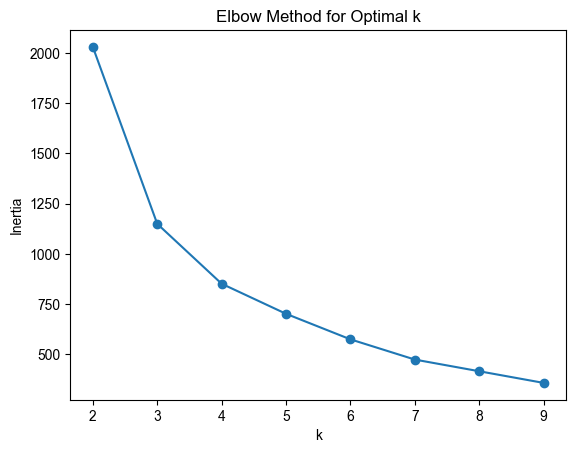

In [38]:
tmp_df11 = deepcopy(df)

# 감성 컬럼만 추출
sentiment_features = ['avg_negative', 'avg_neutral', 'avg_positive']

# 결측치 제거
df_cluster = df.dropna(subset=sentiment_features).copy()

# 감성 컬럼 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[sentiment_features])

# 적절한 클러스터 개수 선택 - Elbow Method
inertias = []
K = range(2, 10)

for k in K :
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

##### KMeans 클러스터링 적용

In [39]:
k = 3   # 선택한 클러스터 수
kmeans = KMeans(n_clusters=k, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# 클러스터별 감성 프로파일 확인
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),  # 원래 감성 값 스케일로 되돌리기
    columns=sentiment_features
)
cluster_centers['cluster'] = cluster_centers.index

cluster_centers

/Users/taeheon/miniforge3/envs/stock_price/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,avg_negative,avg_neutral,avg_positive,cluster
0,0.092760,0.235353,0.671884,0
1,0.511975,0.210144,0.277878,1
2,0.098368,0.636841,0.264798,2


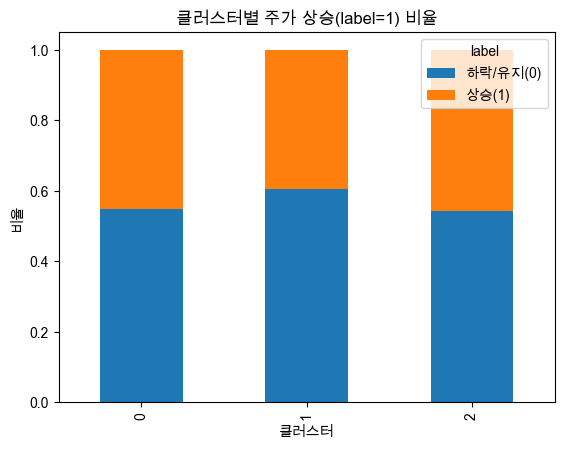

In [40]:
cluster_label_dist = df_cluster.groupby('cluster')['label'].value_counts(normalize=True).unstack()
cluster_label_dist.plot(kind='bar', stacked=True)

plt.title('클러스터별 주가 상승(label=1) 비율')
plt.ylabel('비율')
plt.xlabel('클러스터')
plt.legend(title='label', labels=['하락/유지(0)', '상승(1)'])
plt.show()


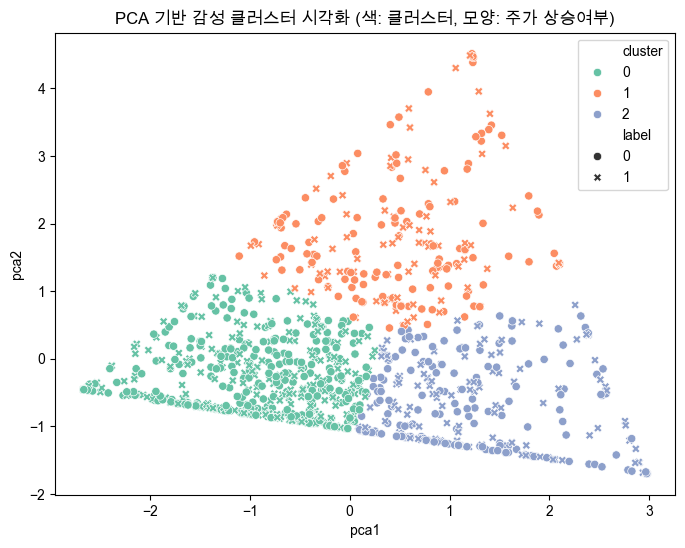

In [41]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_cluster['pca1'] = X_pca[:, 0]
df_cluster['pca2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='pca1', y='pca2', hue='cluster',
    style='label', palette='Set2',
    data=df_cluster
)
plt.title('PCA 기반 감성 클러스터 시각화 (색: 클러스터, 모양: 주가 상승여부)')
plt.show()

##### 시간에 따른 클러스터 출현 시각화
- 감성 유형이 시간 순서상 어떻게 분포했는지 분석

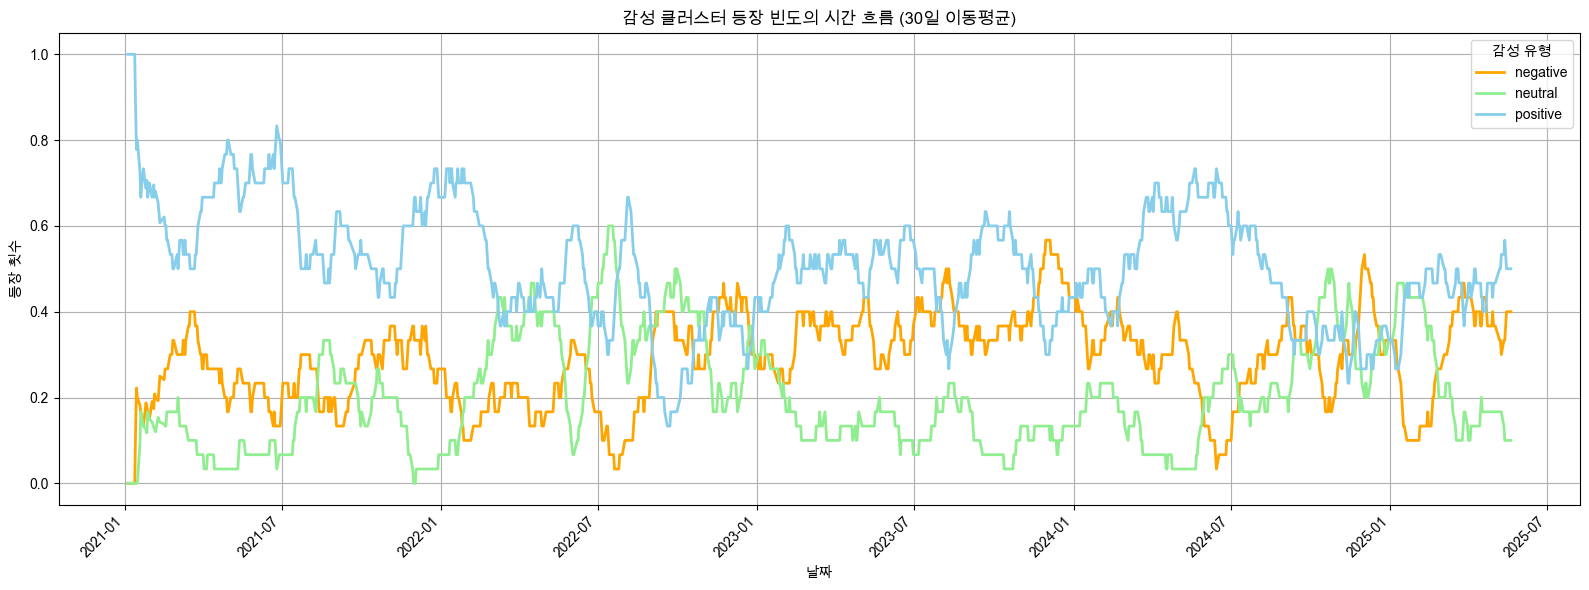

In [53]:
# 클러스터 이름 매핑
cluster_label_map = {0: 'positive', 1: 'neutral', 2: 'negative'}
df_cluster['cluster_name'] = df_cluster['cluster'].map(cluster_label_map)

# 날짜 기준으로 클러스터별 빈도 계산
daily_counts = df_cluster.groupby(['date', 'cluster_name']).size().unstack(fill_value=0)

# 이동평균 적용 (옵션)
smoothed = daily_counts.rolling(window=30, min_periods=1).mean()

# 선 그래프로 시각화
smoothed.plot(
    kind='line',
    figsize=(16, 6),
    color=['orange', 'lightgreen', 'skyblue'],
    linewidth=2
)

plt.title('감성 클러스터 등장 빈도의 시간 흐름 (30일 이동평균)')
plt.xlabel('날짜')
plt.ylabel('등장 횟수')
plt.xticks(rotation=45, ha='right')
plt.legend(title='감성 유형')
plt.grid(True)
plt.tight_layout()
plt.show()

##### 30일 이동평균 기준 감성 클러스터 등장 빈도의 시간 흐름
- x축 : 2021 ~ 2025
- y축 : 감성 클러스터 등장 비율 (0~1)
- 파랑색 : 긍정 / 초록색 : 중립 / 주황색 : 부정

**1. 긍정 감성**
- 전반적으로 가장 높은 비중을 유지
- 특정 시점(2021년 초/중반, 2022년 초/중반, 2024년 초)에는 비율이 0.7~0.8 이상 급등
- 해당 기간에 긍정적 뉴스가 유난히 많았다는 것을 시사

**2. 부정 감성**
- 전반적으로 낮은 비중
- 2022년 후반, 2023년 중반, 2025년 초에 급등 현상
- 해당 기간에 부정적 뉴스가 몰렸음을 시사

**3. 중립 감성**
- 전체 기간 동안 0.2~0.4 사이를 넓게 오가며 비교적 안정된 흐름
- 가끔 긍정과 부정의 교차 지점에서 중립 감성이 상대적으로 커짐

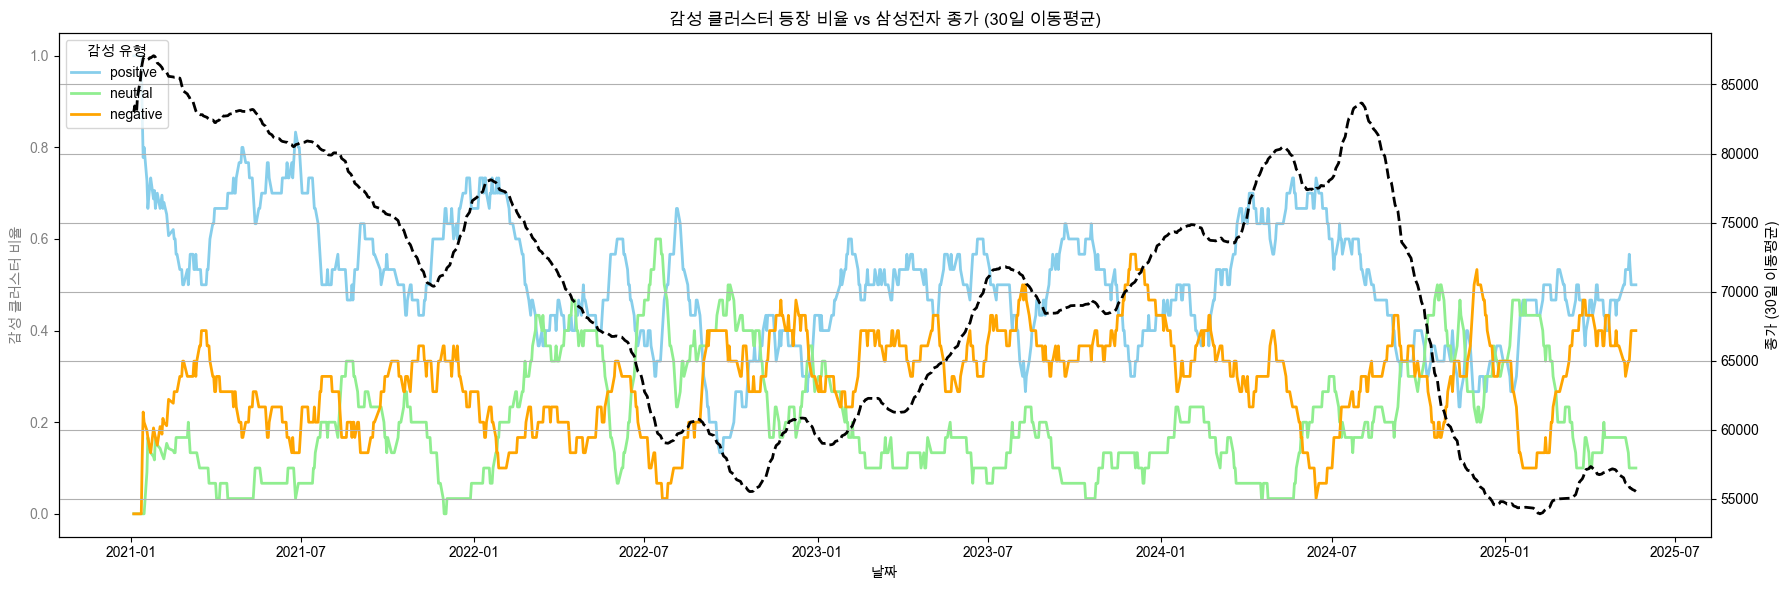

In [54]:
# 종가 시계열 만들기
df_cluster_sorted = df_cluster.sort_values('date')
close_series = df_cluster_sorted.set_index('date')['close']

# 30일 이동평균 계산
close_rolling = close_series.rolling(window=30, min_periods=1).mean()

# 시각화 시작
fig, ax1 = plt.subplots(figsize=(18, 6))

# ▶ 감성 클러스터 등장 비율 (좌측 Y축)
ax1.plot(smoothed.index, smoothed['positive'], label='positive', color='skyblue', linewidth=2)
ax1.plot(smoothed.index, smoothed['neutral'], label='neutral', color='lightgreen', linewidth=2)
ax1.plot(smoothed.index, smoothed['negative'], label='negative', color='orange', linewidth=2)

ax1.set_xlabel('날짜')
ax1.set_ylabel('감성 클러스터 비율', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.legend(loc='upper left', title='감성 유형')
ax1.set_title('감성 클러스터 등장 비율 vs 삼성전자 종가 (30일 이동평균)')

# ▶ 삼성전자 종가 (우측 Y축)
ax2 = ax1.twinx()
ax2.plot(close_rolling.index, close_rolling, label='Close (30d MA)', color='black', linewidth=2, linestyle='--')
ax2.set_ylabel('종가 (30일 이동평균)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# 마무리
fig.tight_layout()
plt.grid(True)
plt.show()


#### 감성 클러스터별 주가 상승(label=1) 확률 분석

감성 클러스터별 주가 상승 확률:

cluster_name
negative    0.458861
neutral     0.452690
positive    0.396313
Name: 주가 상승 확률, dtype: float64


/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_50309/926634100.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




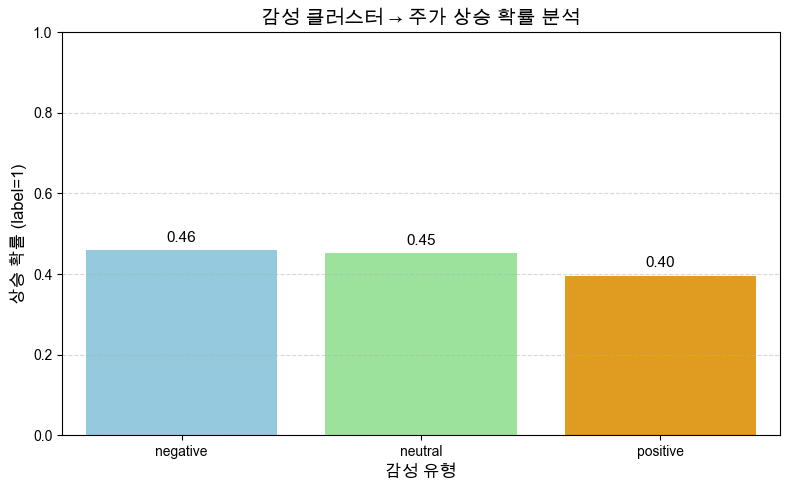

In [44]:
# 1. 클러스터명을 감성 이름으로 매핑
cluster_label_map = {0: 'neutral', 1: 'positive', 2: 'negative'}
df_cluster['cluster_name'] = df_cluster['cluster'].map(cluster_label_map)

# 2. 감성 클러스터별 label=1의 확률 계산 (즉, 상승 확률 평균)
prob_table = (
    df_cluster.groupby('cluster_name')['label']
    .mean()
    .rename('주가 상승 확률')
    .sort_values(ascending=False)
)

# 3. 출력
print("감성 클러스터별 주가 상승 확률:\n")
print(prob_table)

# 4. 시각화
plt.figure(figsize=(8, 5))
sns.barplot(
    x=prob_table.index,
    y=prob_table.values,
    palette=['skyblue', 'lightgreen', 'orange']
)

# 시각화 세부 설정
plt.title('감성 클러스터 → 주가 상승 확률 분석', fontsize=14)
plt.ylabel('상승 확률 (label=1)', fontsize=12)
plt.xlabel('감성 유형', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# 정확한 확률 숫자 표시
for i, v in enumerate(prob_table.values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()


# 7. feature engineering
- EDA 기반 파생변수 생성
    - close_diff : 전일 대비 종가 차이
    - momentum_3d : 3일간 모멘텀
    - sentiment_strenght : 긍정과 부정 간 감정 강도 차이(절댓값)
    - news_density_change : 전날 대비 뉴스 개수 변화량

In [45]:
print(f"원본 데이터프레임 features : {list(df.columns)}")

원본 데이터프레임 features : ['date', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 'news_count', 'avg_negative', 'avg_neutral', 'avg_positive', 'open', 'high', 'low', 'close', 'volume', 'label']


In [47]:
# 이동평균 20일을 위한 21년 1월 1일 이전 주가 데이터 추가 수집
# 수집 기간 지정
start_date = datetime.strptime("2020-12-01", "%Y-%m-%d")
end_date = datetime.strptime("2021-01-01", "%Y-%m-%d")

# 티커 (삼성전자)
samsung = yf.Ticker("005930.KS")

# 전체 기간 동안 주말 포함한 날짜 리스트 생성
date_list = pd.date_range(start=start_date, end=end_date, freq='D').strftime('%Y-%m-%d').tolist()

# 결과 리스트 초기화
all_data = []

for target_date in tqdm(date_list):
    next_date = (datetime.strptime(target_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
    
    hist = samsung.history(start=target_date, end=next_date, auto_adjust=False)

    if not hist.empty:
        hist = hist.reset_index()
        hist.columns = hist.columns.str.lower()
        hist['date'] = pd.to_datetime(hist['date']).dt.date.astype(str)
        hist = hist[['date', 'open', 'high', 'low', 'close', 'volume']]
        all_data.append(hist.iloc[0].to_dict())
    else:
        continue

# 결과 DataFrame 생성
full_df = pd.DataFrame(all_data)

print(f"총 수집 날짜 수 : {len(full_df)}")
# 결과 확인
full_df

  0%|          | 0/32 [00:00<?, ?it/s]$005930.KS: possibly delisted; no price data found  (1d 2020-12-05 -> 2020-12-06)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-06 -> 2020-12-07)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-12 -> 2020-12-13)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-13 -> 2020-12-14)
 53%|█████▎    | 17/32 [00:00<00:00, 162.19it/s]$005930.KS: possibly delisted; no price data found  (1d 2020-12-19 -> 2020-12-20)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-20 -> 2020-12-21)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-25 -> 2020-12-26)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-26 -> 2020-12-27)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-27 -> 2020-12-28)
$005930.KS: possibly delisted; no price data found  (1d 2020-12-31 -> 2021-01-01)
$005930.KS: possibly delisted; no price data found  (1d 2021-01-01 -> 2021-01-02)
100%|███████

총 수집 날짜 수 : 21


,date,open,high,low,close,volume
0,2020-12-01,67100.0,68300.0,67100.0,67800.0,22327173
1,2020-12-02,68400.0,69900.0,68300.0,69500.0,29703942
2,2020-12-03,70100.0,70500.0,69300.0,69700.0,23677989
3,2020-12-04,70400.0,72100.0,70100.0,71500.0,28130533
4,2020-12-07,72400.0,73500.0,71900.0,72900.0,28490496
5,2020-12-08,72200.0,72900.0,71600.0,71700.0,25000338
6,2020-12-09,72100.0,73900.0,72000.0,73900.0,24077996
7,2020-12-10,72700.0,73800.0,72500.0,72900.0,39882928
8,2020-12-11,73500.0,73800.0,73100.0,73400.0,18486672
9,2020-12-14,73600.0,74500.0,73200.0,73800.0,21510415


In [48]:
# 기존 데이터와 concat
tmp_df12 = deepcopy(df)

# 필요한 컬럼 목록 추출 (뉴스 원문 컬럼들 포함)
full_columns = tmp_df12.columns.tolist()

# 없는 컬럼을 full_df에 추가 (값은 NaN)
for col in full_columns:
    if col not in full_df.columns:
        full_df[col] = np.nan

# 컬럼 순서 맞추기
full_df = full_df[full_columns]

# 날짜 기준 오름차순 정렬 보장 (선택사항, 안하면 concat 순서 그대로)
full_df = full_df.sort_values(by='date')

# 위쪽에 full_df 연결
merged_df = pd.concat([full_df, tmp_df12], axis=0).reset_index(drop=True)

print(len(tmp_df12), len(merged_df))
# 결과 확인
merged_df.head(2)

1072 1093


,date,1,2,3,4,5,6,7,8,9,...,news_count,avg_negative,avg_neutral,avg_positive,open,high,low,close,volume,label
0,2020-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,67100.0,68300.0,67100.0,67800.0,22327173,NaN
1,2020-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,68400.0,69900.0,68300.0,69500.0,29703942,NaN


In [49]:
def generate_custom_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # 1. close_diff: 전일 대비 종가 차이
    df['close_diff'] = df['close'].diff()

    # 2. momentum_5d: 5일간의 모멘텀 (현재 종가 - 5일 전 종가)
    df['momentum_5d'] = df['close'] - df['close'].shift(5)

    # 3. momentum_15d: 15일간의 모멘텀
    df['momentum_15d'] = df['close'] - df['close'].shift(15)

    # 4. 5일 이동평균
    df['5ma'] = df['close'].rolling(window=5).mean()

    # 5. 120일 이동평균
    df['20ma'] = df['close'].rolling(window=20).mean()

    # 6. sentiment_strength: 긍정과 부정 간 감정 강도 차이 (절대값)
    df['sentiment_strength'] = (df['avg_positive'] - df['avg_negative']).abs()

    # 7. news_density_change: 전날 대비 뉴스 개수 변화량
    df['news_density_change'] = df['news_count'].diff()

    # 결측치 제거 (NaN 발생 컬럼 기준)
    df.dropna(subset=[
        'close_diff',
        'momentum_5d',
        'momentum_15d',
        '5ma',
        '20ma',
        'news_density_change'
    ], inplace=True)

    return df


In [50]:
tmp_df13 = deepcopy(df)

tmp_df13 = generate_custom_features(tmp_df13)

print(f"파생변수 포함 데이터프레임 features : {list(tmp_df13.columns)}")
tmp_df13.to_csv("250520_weekday_sentiment_stock_feature.csv", index=False)

파생변수 포함 데이터프레임 features : ['date', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 'news_count', 'avg_negative', 'avg_neutral', 'avg_positive', 'open', 'high', 'low', 'close', 'volume', 'label', 'close_diff', 'momentum_5d', 'momentum_15d', '5ma', '20ma', 'sentiment_strength', 'news_density_change']
